# Computational modeling of anthocyanin pathway evolution
### Lucas C. Wheeler  and Stacey D. Smith


## A simple pathway with two main branches: 1) anthocyanins, 2) flavonols. Each has three sub-branches using one of three precursors. Competition between precursors for enzyme binding is an important aspect of the pathway topology.


## This model will allow us to build a quantitative picture of expected behaviors, to improve on our intuitive understanding of pathway activity. 


### Motivation (puzzling observations from the real world)

    1) Some color morphs are more commonly observed than others (i.e. white morphs vs. red morphs in a blue population).
    2) Macroevolutionary trends indicate asymmetric transition rates between states.
    3) There are gaps in the observed phenotype space (i.e no pelargonidin/delphinidin states). 


### Questions:
    1) Do trade-offs arise from pleiotropic effects, such as enzyme competition and substrate competition?
    2) How degenerate are evolutionary trajectories between defined optima (i.e. how many different ways to achieve the same phenotype?) 
    3) Which enzymes contribute the most to evolution between pigment phenotypes?
    4) How does the pathway control structure change to facilitate a new phenotype? 

   
### General irreversible rate law *ignoring* substrate competition

## $v_1$ = $\frac{k_{cat_1}E_{t}S_{1}}{(K_{m_1} + S_{1})}$

Where, $K_{m_1}$ is the Michaelis constant (effectively a binding constant), $k_{cat_1}$ is the turnover rate ($s^{-1}$), $E_{t}$ is the total enzyme concentration, and $S_{1}$ is the total substrate concentration.

### General irreversible rate law *incorporating* substrate competition

We KNOW that there is substrate competition in the anthocyanin pathway, so I have elected to use this form of the rate law on biological grounds. There are no additional parameters.

## $v_1$ = $\frac{k_{cat_1}E_{t}S_{1}}{(K_{m_1}(1 + \sum_{i=2}^{n}\frac{S_{i}}{Km_{i}}) + S_{1})}$

## Import all of the packages I need to build and run the simulations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
te.setDefaultPlottingEngine('matplotlib')
import seaborn as sns
import pandas as pd
from copy import copy, deepcopy
import roadrunner
import pickle
from enzo import Pathway, PathwaySet # This is our custom evolutionary wrapper for Tellurium
import joypy
import os

# A simplified model of a portion of the flavonoid pathway, including coarse-grained version of flavonol and anthocyanin biosythensis branches. (Irreversible reactions incorporating substrate competition)

/home/lcwheeler/py3/lib/python3.6/site-packages/pygraphviz/agraph.py:1338: RuntimeWarning:





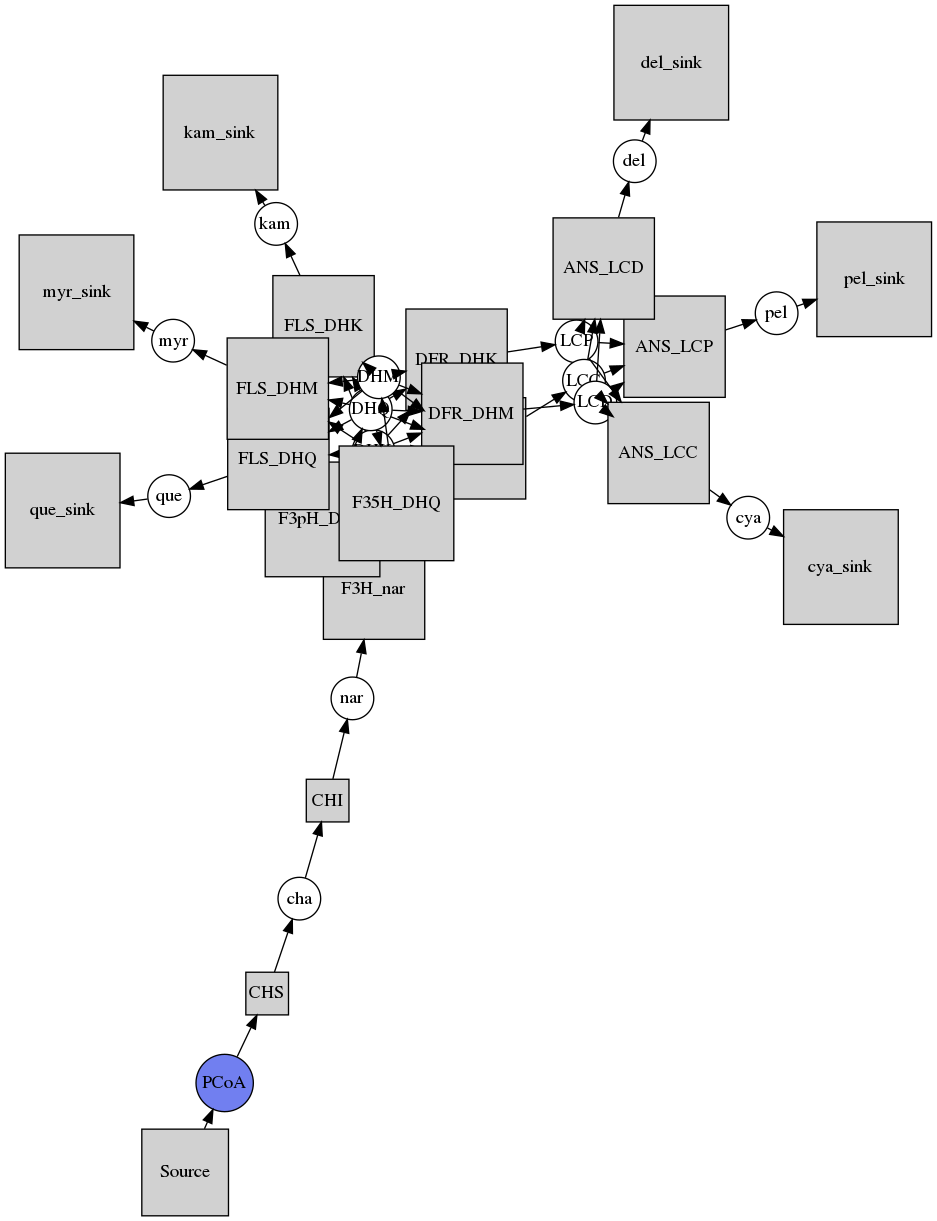

In [2]:
# Initialize a Tellurium/Roadrunner model encoding the pathway topology and rate laws (specified in supplemental text)
r = te.loada('''
    
    # Constant source entering model
    Source: => PCoA;
    
    # Rate laws for all the central enzymatic reactions
    
    CHS: PCoA => cha; (k_CHS_PCoA*CHSt*PCoA)/(Km_CHS_PCoA + PCoA);
    
    CHI: cha => nar; (k_CHI_cha*CHIt*cha)/(Km_CHI_cha + cha);
    

    F3H_nar: nar => DHK; (k_F3H_nar*F3Ht*nar)/(Km_F3H_nar + nar);
    
    
    F3pH_DHK: DHK => DHQ; (k_F3pH_DHK*F3pHt*DHK)/(Km_F3pH_DHK + DHK);
    
    
    F35H_DHQ: DHQ => DHM; (k_F35H_DHQ*F35Ht*DHQ)/(Km_F35H_DHQ + DHQ);
    
    
    FLS_DHK: DHK => kam; (k_FLS_DHK*FLSt*DHK)/(Km_FLS_DHK * (1 + DHQ/Km_FLS_DHQ + DHM/Km_FLS_DHM) + DHK);
    
    FLS_DHQ: DHQ => que; (k_FLS_DHQ*FLSt*DHQ)/(Km_FLS_DHQ * (1 + DHM/Km_FLS_DHM + DHK/Km_FLS_DHK) + DHQ);
    
    FLS_DHM: DHM => myr; (k_FLS_DHM*FLSt*DHM)/(Km_FLS_DHM * (1 + DHK/Km_FLS_DHK + DHQ/Km_FLS_DHQ) + DHM);
    
    
    DFR_DHK: DHK => LCP; (k_DFR_DHK*DFRt*DHK)/(Km_DFR_DHK * (1 + DHQ/Km_DFR_DHQ + DHM/Km_DFR_DHM) + DHK);
    
    DFR_DHQ: DHQ => LCC; (k_DFR_DHQ*DFRt*DHQ)/(Km_DFR_DHQ * (1 + DHK/Km_DFR_DHK + DHM/Km_DFR_DHM) + DHQ);
    
    DFR_DHM: DHM => LCD; (k_DFR_DHM*DFRt*DHM)/(Km_DFR_DHM * (1 + DHK/Km_DFR_DHK + DHQ/Km_DFR_DHQ) + DHM);
    
    
    ANS_LCP: LCP => pel; (k_ANS_LCP*ANSt*LCP)/(Km_ANS_LCP * (1 + LCC/Km_ANS_LCC + LCD/Km_ANS_LCD) + LCP);
    
    ANS_LCC: LCC => cya; (k_ANS_LCC*ANSt*LCC)/(Km_ANS_LCC * (1 + LCP/Km_ANS_LCP + LCD/Km_ANS_LCD) + LCC);
    
    ANS_LCD: LCD => del; (k_ANS_LCD*ANSt*LCD)/(Km_ANS_LCD * (1 + LCP/Km_ANS_LCP + LCC/Km_ANS_LCC) + LCD);
    

    # Product sinks
    
    pel_sink: pel =>; k_pel_sink*pel;
    
    cya_sink: cya =>; k_cya_sink*cya;
    
    del_sink: del =>; k_del_sink*del;
    

    kam_sink: kam =>; k_kam_sink*kam;
    
    que_sink: que =>; k_que_sink*que;
    
    myr_sink: myr =>; k_myr_sink*myr;
    
        
    # Substrate Kcat's
    k_CHS_PCoA=14; k_CHI_cha=14; k_F3H_nar=14; 
    k_F3pH_DHK=14; k_F35H_DHQ=14; k_FLS_DHK=14; 
    k_FLS_DHQ=14; k_FLS_DHM=14; k_DFR_DHK=14; k_DFR_DHQ=14; k_DFR_DHM=14; k_ANS_LCP=14; k_ANS_LCC=14;
    k_ANS_LCD=14; 
   
    # Substrate Km's
    Km_CHS_PCoA=0.013; Km_CHI_cha=0.013;  
    Km_F3H_nar=0.013; Km_F3pH_DHK=0.013; Km_F35H_DHQ=0.013; 
    Km_FLS_DHK=0.013; Km_FLS_DHQ=0.013; Km_FLS_DHM=0.013; 
    Km_DFR_DHK=0.013; Km_DFR_DHQ=0.013; Km_DFR_DHM=0.013;  
    Km_ANS_LCP=0.013; Km_ANS_LCC=0.013; Km_ANS_LCD=0.013;


    # Enzyme concentrations
    CHSt=0.001; CHIt=0.001; F3Ht=0.001; F3pHt=0.001;
    F35Ht=0.001; FLSt=0.001; DFRt=0.001; ANSt=0.001; 

    
    # Rates for sinks 
    k_pel_sink=0.0005; k_cya_sink=0.0005; k_del_sink=0.0005; 
    k_kam_sink=0.0005; k_que_sink=0.0005; k_myr_sink=0.0005; 
    
    # Source influx
    const PCoA = 0.01;
    #PCoA = 1000;
''')

r.draw()

In [3]:
# Print out an SBML version of the pathway model
print(r.getSBML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by libAntimony version v2.9.4 with libSBML version 5.15.0. -->
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model id="__main" name="__main">
    <listOfCompartments>
      <compartment sboTerm="SBO:0000410" id="default_compartment" spatialDimensions="3" size="1" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="PCoA" compartment="default_compartment" initialConcentration="0.01" hasOnlySubstanceUnits="false" boundaryCondition="true" constant="false"/>
      <species id="cha" compartment="default_compartment" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="nar" compartment="default_compartment" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="DHK" compartment="default_compartment" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="D

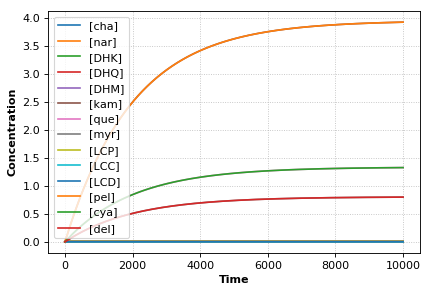

In [3]:
#r.conservedMoietyAnalysis = True
r.integrator = 'cvode' #'cvode' is the numerical non-stochastic solver
r.resetToOrigin() #This prevents the model from retaining memory of simulation
rsim = r.simulate(0, 10000, 1000)
currentDir = os.getcwd()
r.plot(xtitle="Time", ytitle="Concentration", dpi=600, savefig="timecourse-main-model.pdf")

In [4]:
RSIM = pd.DataFrame(rsim, columns=[name for name in rsim.colnames])

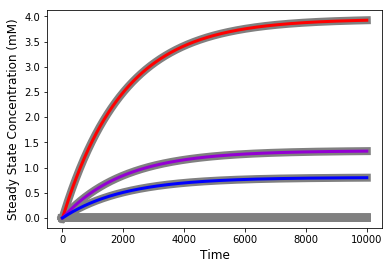

In [5]:
# Build a color dict to color the concentration plot 
colors = {}

for c in list(r.getFloatingSpeciesIds()):
    colors[c] = "gray"
    
colors["del"] = "blue"
colors["pel"] = "red"
colors["cya"] = "purple"

for column in RSIM.columns:
    if "time" not in column:
        if "pel" in column: 
            sns.lineplot(RSIM["time"], RSIM[column], color="red", linewidth=3)
        elif "del" in column:
            sns.lineplot(RSIM["time"], RSIM[column], color="blue", linewidth=3)
        elif "cya" in column:
            sns.lineplot(RSIM["time"], RSIM[column], color="darkviolet", linewidth=3)
        else:
            sns.lineplot(RSIM["time"], RSIM[column], color="gray", linewidth=8)
            
        
plt.xlabel("Time", fontsize=12)
plt.ylabel("Steady State Concentration (mM)", fontsize=12);
#plt.savefig("main-model-timecourse.png", format="png", dpi=600)
#plt.savefig("main-model-timecourse.pdf", format="pdf")

In [6]:
r.steadyState()

2.484219262025196e-19

The total concentration is 12.201135265700483mM


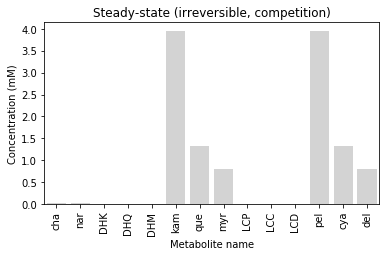

In [4]:
#r.conservedMoietyAnalysis = True
SS_selections = r.steadyStateSelections = list(r.getFloatingSpeciesIds()) 
SS_values = r.getSteadyStateValues()

sns.barplot(SS_selections, SS_values, color="lightgray")
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.15)
plt.title("Steady-state (irreversible, competition)")
plt.ylabel("Concentration (mM)")
plt.xlabel("Metabolite name");
plt.gcf().subplots_adjust(bottom=0.25)
print("The total concentration is " + str(np.sum(SS_values)) + "mM")
#plt.savefig("steady-state-concentrations-starting-state.pdf")

In [5]:
print(SS_selections)
print(SS_values)
print((SS_values[11]/np.sum(SS_values))*100)
print((SS_values[12]/np.sum(SS_values))*100)
print((SS_values[13]/np.sum(SS_values))*100)

['cha', 'nar', 'DHK', 'DHQ', 'DHM', 'kam', 'que', 'myr', 'LCP', 'LCC', 'LCD', 'pel', 'cya', 'del']
[1.00000000e-02 1.00000000e-02 2.34285309e-03 7.91562951e-04
 4.76695070e-04 3.94915705e+00 1.33427334e+00 8.03526138e-01
 2.34285309e-03 7.91562951e-04 4.76695070e-04 3.94915705e+00
 1.33427334e+00 8.03526138e-01]
32.36712782928785
10.935649073492758
6.5856669935068615


### Calculate concentration control coefficients for each of the reactions and organize as pandas.DataFrame
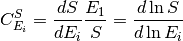

In [6]:
CC = r.getScaledConcentrationControlCoefficientMatrix()
CC_df = pd.DataFrame(CC, columns=[name for name in CC.colnames], index=[name for name in CC.rownames])
CC_df.drop(["Source", "kam_sink", "myr_sink", "que_sink", "pel_sink", "cya_sink", "del_sink"], axis = 1, inplace = True)
CC_df

,CHS,CHI,F3H_nar,F3pH_DHK,F35H_DHQ,FLS_DHK,FLS_DHQ,FLS_DHM,DFR_DHK,DFR_DHQ,DFR_DHM,ANS_LCP,ANS_LCC,ANS_LCD
cha,1.769232,-1.769232,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nar,1.769232,0.000000,-1.769232,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DHK,1.247101,0.000000,0.000000,-0.371113,-3.712529e-16,-0.404553,-0.020872,-0.012569,-0.404553,-0.020872,-0.012569,0.000000,0.000000,0.000000
DHQ,1.257160,0.000000,0.000000,0.700672,-3.841532e-01,-0.407816,-0.356443,-0.022580,-0.407816,-0.356443,-0.022580,0.000000,0.000000,0.000000
DHM,1.462783,0.000000,0.000000,0.660457,6.378951e-01,-0.474520,-0.366429,-0.539619,-0.474520,-0.366429,-0.539619,0.000000,0.000000,0.000000
kam,0.969323,0.000000,0.000000,-0.371113,1.720413e-16,0.685556,0.009573,0.005765,-0.314444,0.009573,0.005765,0.000000,0.000000,0.000000
que,0.979382,0.000000,0.000000,0.700672,-3.841532e-01,-0.317707,0.674002,-0.004246,-0.317707,-0.325998,-0.004246,0.000000,0.000000,0.000000
myr,1.185005,0.000000,0.000000,0.660457,6.378951e-01,-0.384410,-0.335985,0.478716,-0.384410,-0.335985,-0.521284,0.000000,0.000000,0.000000
LCP,1.247101,0.000000,0.000000,-0.371113,8.710163e-16,-0.404553,-0.020872,-0.012569,0.775666,0.040018,0.024100,-1.180219,-0.060889,-0.036669
LCC,1.257160,0.000000,0.000000,0.700672,-3.841532e-01,-0.407816,-0.356443,-0.022580,-0.227597,0.704447,0.014089,-0.180219,-1.060889,-0.036669


### Plot a heatmap showing the control coefficients of each reaction for each substrate

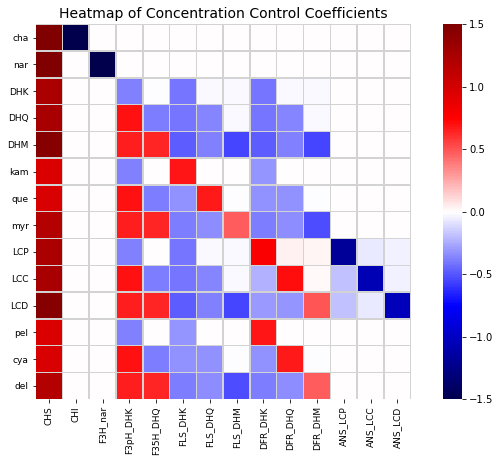

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(CC_df, square=True, linewidths=0.5, cmap="seismic", linecolor="lightgray", vmax=1.5, vmin=-1.5)

plt.gcf().subplots_adjust(bottom=0.25)
#plt.rcParams["font.family"] = "georgia"

plt.title("Heatmap of Concentration Control Coefficients", fontsize=14);
ax.tick_params(axis='both', which='both', labelsize=9)
plt.yticks(rotation=-360);

#plt.savefig("control-coefficients-heatmap.pdf", format="pdf")
#plt.savefig("control-coefficients-heatmap.png", format="png", dpi=600)

### Calculate the elasticities of each enzyme with respect to changes in each substrate concentration
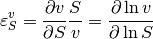

In [8]:
EC = r.getScaledElasticityMatrix()
EC_df = pd.DataFrame(EC, columns=[name for name in EC.colnames], index=[name for name in EC.rownames])
EC_df.drop(["Source", "kam_sink", "myr_sink", "que_sink", "pel_sink", "cya_sink", "del_sink"], inplace = True)
EC_df

,cha,nar,DHK,DHQ,DHM,kam,que,myr,LCP,LCC,LCD,pel,cya,del
CHS,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
CHI,0.565217,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
F3H_nar,0.000000,0.565217,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
F3pH_DHK,0.000000,0.000000,0.847300,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
F35H_DHQ,0.000000,0.000000,0.000000,0.942605,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
FLS_DHK,0.000000,0.000000,0.858959,-0.047653,-0.028697,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
FLS_DHQ,0.000000,0.000000,-0.141041,0.952347,-0.028697,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
FLS_DHM,0.000000,0.000000,-0.141041,-0.047653,0.971303,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
DFR_DHK,0.000000,0.000000,0.858959,-0.047653,-0.028697,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
DFR_DHQ,0.000000,0.000000,-0.141041,0.952347,-0.028697,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


### Plot the reaction elasticities as a heatmap

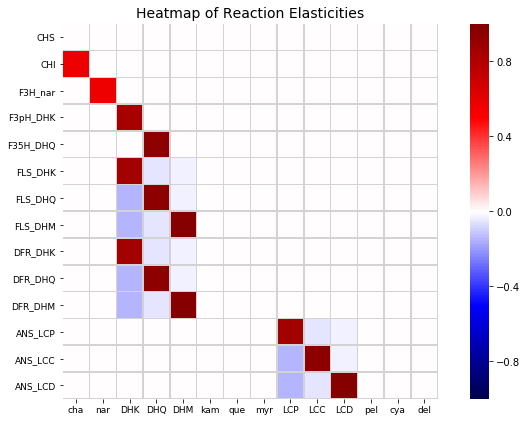

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.heatmap(EC_df, square=True, linewidths=0.5, cmap="seismic", linecolor="lightgray", vmax=1, vmin=-1)
plt.gcf().subplots_adjust(bottom=0.25)
plt.rcParams["font.family"] = "georgia"

plt.title("Heatmap of Reaction Elasticities", fontsize=14)

ax.tick_params(axis='both', which='both', labelsize=9)
#plt.savefig("elasticities-heatmap.pdf", format="pdf")
#plt.savefig("elasticities-heatmap.png", format="png", dpi=600)

# Evolution of the simple pathway from one optimum (pigment profile) to another

### Use a simple model of evolution to evolve the pathway toward an optimum in the model state space. Optimum is represented by constraints on the steady state species concentrations. Then map the evolutionary trajectories through the underlying parameters onto the model state space diagram. 

## Example Steady State optimum ($SS_{opt}$)

## $\frac{[Delphinidin]}{\sum_{i=1}^{n}S_{i}}$ $=$ $0.5$ $\pm$ $0.005$

Where, $S_{i}$ are the steady state concentrations of each of the $n$ species in the pathway. 

## Approach
#### Constrain the total flux to within a narrow range around that of the starting state.
    Iterate over evolutionary steps
    1) At each step draw a random parameter.
    2) For the random parameter draw a random fraction and multiply by param value then add or subtract.
    3) Test steady state condition and calculate distance to optimum (i.e. use fitness function).
    4) Calculate fixation probability assuming stabilizing selection (with some probability i.e. a Monte-Carlo type process) with which to accept or reject. 
    5) Move on to the next step. 
    Repeat for many simulations and summarize the full set of trajectories  

## Import 10000 saved trajectories and plot/analyze

I previously simulated these trajectories and stored the complete objects in a compressed file format

In [3]:
dataset = pickle.load(open("all_params_10000_del90_final_reformulated.p", "rb"))

In [4]:
dataset.collate_data()

The total concentration is 12.214334114480158mM
The ratio of the target species to all others species is 0.943340409180095


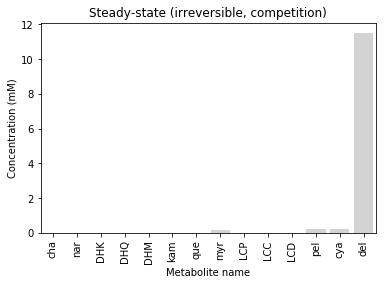

In [5]:
dataset.pathway_set[0].plot_ss()

In [18]:
# Check to make sure that all the trajectories found an optimum. If not then print the indexes of the bad ones.
# Will discard these bad simulations later, along with any that have flagged numerical errors
bad = []
good = []
for key in dataset.pathway_set.keys():
    if len(dataset.pathway_set[key].optima) > 0:
        good.append(dataset.pathway_set[key].optima)
    else: 
        bad.append(key)
        print("bad ", key)
        
print(len(good))
print(len(bad))

bad = []
good = []

bad  267
bad  853
bad  917
bad  3266
bad  5203
bad  5971
bad  6001
bad  6640
bad  6672
bad  7198
bad  7539
bad  8615
bad  9396
bad  9842
bad  9880
9985
15


## Plot the average steady state concentration of all species at the optima

In [19]:
# Grab just the last row (optimum) steady state concentrations from each simulation and build a new DataFrame
# that I can use to calculate column means, plot distributions, etc. 

# Create a dictionary of row values for each species
fss = {}
no_optima = []

for key in dataset.pathway_set.keys():
    # Check to make sure that the simulation didn't have any numerical errors in mca and that it found optimum
    if not hasattr(dataset.pathway_set[key], 'mca_error') and len(dataset.pathway_set[key].optima) > 0:
        fss[key] = dataset.pathway_set[key].concentrations.values[-1].tolist()
        
    else:
        no_optima.append(key)
        pass
print("These are the indexes for pathways that didn't reach optimum!")
print(no_optima)

These are the indexes for pathways that didn't reach optimum!
[267, 853, 917, 3266, 5203, 5971, 6001, 6640, 6672, 7198, 7539, 8615, 9396, 9842, 9880]


In [20]:
# Convert the dictionary to a pandas dataframe with species columns, values from each step in rows 
fss = pd.DataFrame(fss)
fss.index = ['cha', 'nar', 'DHK', 'DHQ', 'DHM', 'kam', 'que', 'myr', 'LCP', 'LCC', 'LCD', 'pel', 'cya', 'del']
fss = fss.T

In [21]:
# Build a color dict to color the concentration plot 
colors = {}

for c in list(dataset.pathway_set[0].concentrations.tail(1)):
    colors[c] = "gray"
    
colors["del"] = "blue"
colors["pel"] = "red"
colors["cya"] = "purple"

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



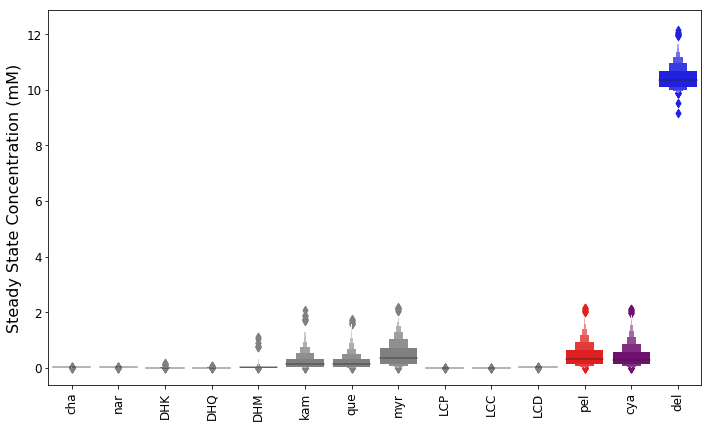

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.boxenplot(data=fss.reindex(sorted(fss.columns), axis=1), palette=colors, order=['cha', 'nar', 'DHK', 'DHQ', 'DHM', 'kam', 'que', 
                                                                                    'myr', 'LCP', 'LCC', 'LCD', 'pel', 'cya', 'del'])

plt.xticks(rotation=90, fontsize=12);
plt.yticks(fontsize=12)
plt.ylabel("Steady State Concentration (mM)", fontsize=16);
plt.gcf().subplots_adjust(bottom=0.25);
#plt.savefig("steady-state-concentration-distributions.pdf", format="pdf")
#plt.savefig("steady-state-concentration-distributions.png", format="png", dpi=600)

## Calculate the number of states with red/blue, red/purple, purple/blue, red/purple/blue
This is relevant to the idea of rarity/inaccessibility of regions in the pathway state space. 

In [9]:
dataset.pathway_set[0].concentrations.iloc[-1]

cha     0.010000
nar     0.010000
DHK     0.000646
DHQ     0.000635
DHM     0.009370
kam     0.004351
que     0.009879
myr     0.145747
LCP     0.000202
LCC     0.000198
LCD     0.009370
pel     0.248115
cya     0.243546
del    11.522275
Name: 10, dtype: float64

In [25]:
pel_opt = 0
cya_opt = 0
pel_cya_opt = 0
neither = 0

# Iterate over all the Pathway objects in the dataset and count all the states satifying defined conditions

for key in dataset.pathway_set.keys():
    Sum = np.sum(dataset.pathway_set[key].concentrations.iloc[-1])
    
    if dataset.pathway_set[key].concentrations.iloc[-1]["pel"]/Sum >= 0.1 and dataset.pathway_set[key].concentrations.iloc[-1]["cya"]/Sum <= 0.1:
        pel_opt += 1
        
    elif dataset.pathway_set[key].concentrations.iloc[-1]["pel"]/Sum <= 0.1 and dataset.pathway_set[key].concentrations.iloc[-1]["cya"]/Sum >= 0.1:
        cya_opt += 1
        
    elif dataset.pathway_set[key].concentrations.iloc[-1]["pel"]/Sum >= 0.1 and dataset.pathway_set[key].concentrations.iloc[-1]["cya"]/Sum >= 0.1:
        pel_cya_opt += 1
    
    else:
        neither += 1
        


In [26]:
print(pel_opt/9999)
print(cya_opt/9999)
print(pel_cya_opt/9999)
print(neither/9999)

0.056105610561056105
0.0442044204420442
0.0
0.8997899789978998


### Calculate and plot all pairwise correlations between steady state concentrations of each species

This is a coarse-grained picture of the constraints and trade-offs inherent to the pathway

In [6]:
# Calculate the pairwise correlations within each simulation
C = []
for i in range(len(dataset.pathway_set)):
    c = dataset.pathway_set[i].concentrations.corr(method="spearman")
    C.append(c)
CC = pd.concat(C)

In [7]:
species_order = list(dataset.pathway_set[0].concentrations.columns)
species_order

['cha',
 'nar',
 'DHK',
 'DHQ',
 'DHM',
 'kam',
 'que',
 'myr',
 'LCP',
 'LCC',
 'LCD',
 'pel',
 'cya',
 'del']

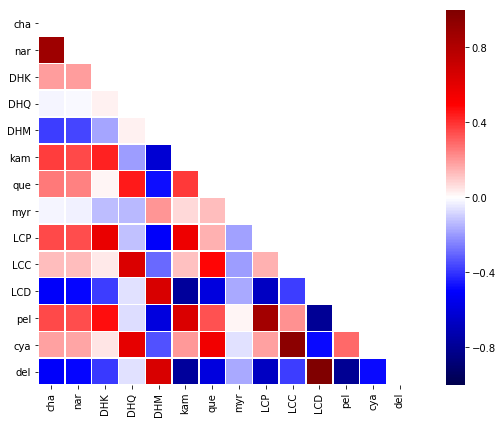

In [8]:
# This will be a figure included in the paper, showing overall floating species correlations
by_row_index = CC.groupby(CC.index)
CC_means = by_row_index.mean()

CC_means = CC_means.reindex(species_order)
#CC_means = CC_means.round(decimals=2)

# Generate a mask for the upper triangle
mask = np.zeros_like(CC_means, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot a matrix of correlations
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.heatmap(CC_means, mask=mask, square=True, linewidths=0.5, cmap="seismic", vmin=-1, vmax=1)

plt.gcf().subplots_adjust(bottom=0.25)
ax.tick_params(axis='both', which='both', labelsize=10)


plt.xticks(rotation=90)
plt.yticks(rotation=-360);

#plt.savefig("steady-state-species-spearman-correlations.pdf", format="pdf")

In [9]:
CC_means.round(decimals=2) 

,cha,nar,DHK,DHQ,DHM,kam,que,myr,LCP,LCC,LCD,pel,cya,del
cha,1.00,0.88,0.19,-0.02,-0.38,0.38,0.26,-0.02,0.35,0.13,-0.51,0.35,0.18,-0.51
nar,0.88,1.00,0.19,-0.01,-0.36,0.36,0.25,-0.03,0.35,0.13,-0.49,0.34,0.18,-0.49
DHK,0.19,0.19,1.00,0.03,-0.17,0.43,0.02,-0.13,0.58,0.04,-0.38,0.47,0.05,-0.38
DHQ,-0.02,-0.01,0.03,1.00,0.03,-0.19,0.45,-0.13,-0.12,0.65,-0.06,-0.07,0.60,-0.06
DHM,-0.38,-0.36,-0.17,0.03,1.00,-0.62,-0.47,0.20,-0.51,-0.29,0.65,-0.59,-0.34,0.65
kam,0.38,0.36,0.43,-0.19,-0.62,1.00,0.39,0.07,0.57,0.12,-0.77,0.64,0.20,-0.78
que,0.26,0.25,0.02,0.45,-0.47,0.39,1.00,0.13,0.15,0.49,-0.59,0.34,0.55,-0.59
myr,-0.02,-0.03,-0.13,-0.13,0.20,0.07,0.13,1.00,-0.18,-0.19,-0.17,0.02,-0.06,-0.17
LCP,0.35,0.35,0.58,-0.12,-0.51,0.57,0.15,-0.18,1.00,0.15,-0.66,0.86,0.18,-0.67
LCC,0.13,0.13,0.04,0.65,-0.29,0.12,0.49,-0.19,0.15,1.00,-0.38,0.21,0.95,-0.38


In [10]:
CC_means.to_csv("concentration-correlation-matrix.csv")

### Calculate number of fixation events for each parameter across all trajectories

In [9]:
param_counts = {}

for key in dataset.pathway_set.keys():
    for p in dataset.pathway_set[key].parameters:
        param_counts[p[0]] = 0

for key in dataset.pathway_set.keys():
    for p in dataset.pathway_set[key].parameters:
        param_counts[p[0]] += 1
        

In [10]:
order = sorted(list(dataset.fitness_effects.keys()))

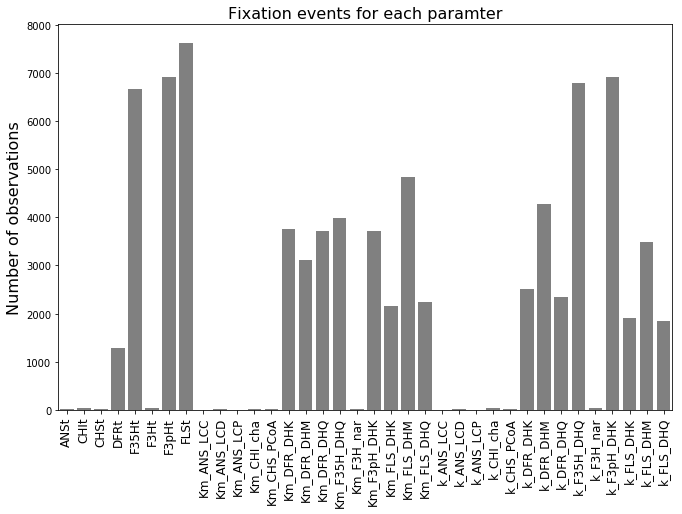

In [11]:
# It might be cool to draw the pathway with enzymes as circles and scale the circle size by 
# the number of fixed mutations at that gene. 

fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

#sns.barplot(list(param_counts.keys()), np.log10(list(param_counts.values())), order=order, color="gray")
sns.barplot(list(param_counts.keys()), list(param_counts.values()), order=order, color="gray")
plt.xticks(rotation=90, fontsize=12);
plt.title("Fixation events for each paramter", fontsize=16)
plt.ylabel("Number of observations", fontsize=16);
plt.gcf().subplots_adjust(bottom=0.25);
#plt.savefig("fixation-counts.pdf", format="pdf")

### Plot the distributions as boxplots and overlay the min and max values

In [185]:
# Convert the fitness effects dictiontary into a DataFrame with missing data
F = pd.DataFrame.from_dict(dataset.fitness_effects, orient='index').T

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



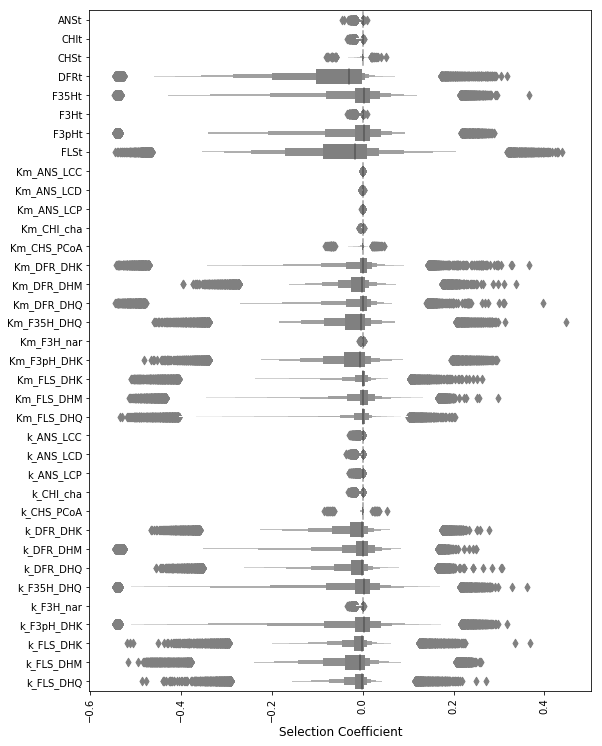

In [186]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 15)

sns.boxenplot(data=F.reindex(sorted(F.columns), axis=1), color="gray", orient="h");

#plt.plot(S.iloc[0].reindex(sorted(S.columns), axis=0), "bo");
#plt.plot(S.iloc[1].reindex(sorted(S.columns), axis=0), "ro");
#plt.ylim(-1, 1)
#plt.title("Distributions of fitness effects for all parameters", fontsize = 16)
plt.xlabel("Selection Coefficient", fontsize=12)
plt.xticks(rotation=90);
#plt.axvline(x=0, linewidth=1, color="Orange");
plt.gcf().subplots_adjust(bottom=0.25);
plt.savefig("dfe-all-parameters-vertical.pdf", format="pdf")
#plt.savefig("dfe-all-parameters-vertical.png", format="png")

In [188]:
F = F[F.columns.drop(list(F.filter(regex='CHI')))]
F = F[F.columns.drop(list(F.filter(regex='ANS')))]
F = F[F.columns.drop(list(F.filter(regex='F3H')))]
F = F[F.columns.drop(list(F.filter(regex='CHS')))]

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



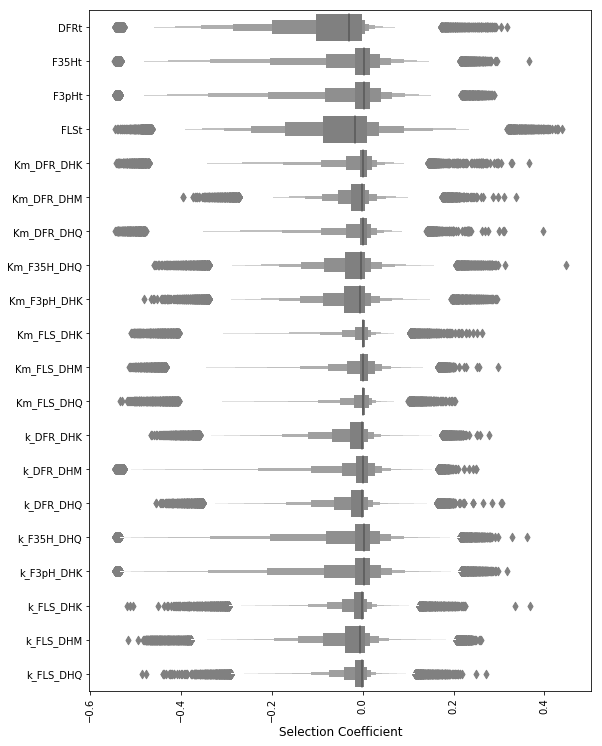

In [190]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 15)

sns.boxenplot(data=F.reindex(sorted(F.columns), axis=1), color="gray", orient="h");

#plt.plot(S.iloc[0].reindex(sorted(S.columns), axis=0), "bo");
#plt.plot(S.iloc[1].reindex(sorted(S.columns), axis=0), "ro");
#plt.ylim(-1, 1)
#plt.title("Distributions of fitness effects for all parameters", fontsize = 16)
plt.xlabel("Selection Coefficient", fontsize=12)
plt.xticks(rotation=90);
#plt.axvline(x=0, linewidth=1, color="Orange");
plt.gcf().subplots_adjust(bottom=0.25);
plt.savefig("dfe-main-target-parameters-vertical.pdf", format="pdf")
#plt.savefig("dfe-all-parameters-vertical.png", format="png")

### Calculate the distribution of parameter change directions across all trajectories
An improved version of this (just looking at shifts in final optimal parameter values) broken up by parameter type is shown further down in this notebook. 

In [17]:
# Get a dictionary with each param as key and a [ref. param value, []] structure for the values. 
# Iterate over all of the trajectories and grab the param value tuple[1] from "parameters"
# Subtract the ref. param value from the current param value and append to the list in dict

directions = {}
reference = {}

# Prepare two dictionaries for calcuating and collecting the directionality data
for key in dataset.params:
    reference[key] = getattr(r, key)
    directions[key] = []
    
# Collate all the mutation direction data from across the trajectories
for key in dataset.pathway_set.keys():
    for p in dataset.pathway_set[key].parameters:
        delta = (p[1] - reference[p[0]])/reference[p[0]]
        
        directions[p[0]].append(delta)
        
# Convert all the data into a pandas DataFrame
D = pd.DataFrame.from_dict(directions, orient='index').T

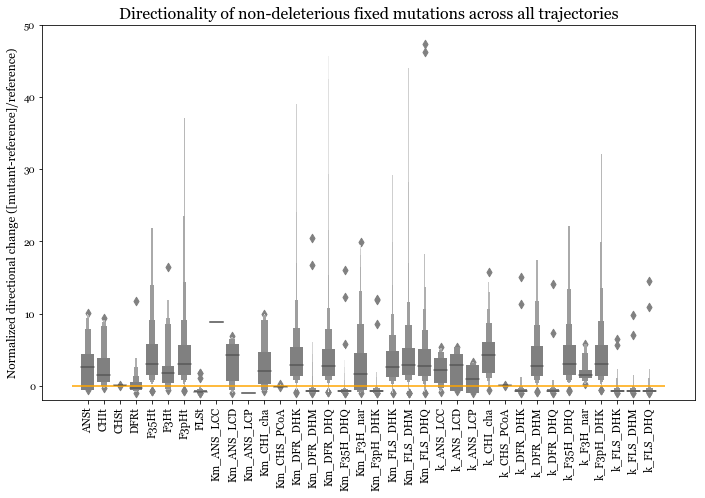

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxenplot(data=D.reindex(sorted(D.columns), axis=1), color="gray")# palette="muted");
#plt.plot(D.median().reindex(sorted(D.columns),axis=1), "m-")
plt.hlines(0, -1, 36, colors="orange")

plt.title("Directionality of non-deleterious fixed mutations across all trajectories", fontsize=16)
plt.ylabel("Normalized directional change ([mutant-reference]/reference)", fontsize=12)
plt.ylim(-2, 50)
plt.xticks(rotation=90, fontsize=11);
plt.gcf().subplots_adjust(bottom=0.25);
#plt.savefig("mutational-directionality-factors.pdf", format="pdf")

## Mean trajectory through pel/cya/del space

In [ ]:
# Need to make a new dataframes for pel, del, and cya (separately) that contain a colum for each infividual
# trajectory/simulation from the PathwaySet. Then can take the mean and stdv of each and make a new collected
# dataframe with means and stdvs at each step. 

In [86]:
lengths = {}
for key in dataset.pathway_set.keys():
    lengths[key] = len(dataset.pathway_set[key].concentrations)
    
print(max(lengths.values()))
print(min(lengths.values()))

92
3


In [87]:
max(lengths, key=lengths.get)

853

In [88]:
print(np.mean(list(lengths.values())))
print(np.median(list(lengths.values())))
print(np.std(list(lengths.values())))

9.043
9.0
2.524193138410767


In [89]:
sigma2_high = np.mean(list(lengths.values())) + 2* np.std(list(lengths.values()))
sigma2_low = np.mean(list(lengths.values())) - 2* np.std(list(lengths.values()))
print(sigma2_low, sigma2_high)

3.994613723178465 14.091386276821535


In [46]:
lengths[853]

92

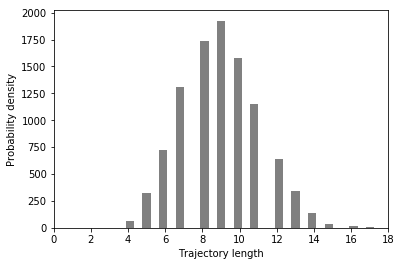

In [91]:
# This is probably going to be a figure (include distribution for each parameter type condition)
#sns.distplot(list(lengths.values()), color="gray");
plt.hist(list(lengths.values()), bins = 200, density = False, color="gray");
plt.xlim(0,18)
plt.xlabel("Trajectory length")
plt.ylabel("Probability density")
#plt.savefig("trajectory-len-dist-counts.pdf", format="pdf")

The total concentration is 12.195193966991402mM
The ratio of the target species to all others species is 0.27675488831331935


/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



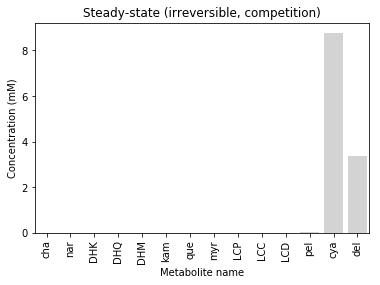

In [52]:
dataset.pathway_set[853].plot_ss() #Looks like this one never reached the optimum! (confirmed above "bad  853")

In [64]:
# Generate a pelargonidin dataframe
pelargonidin = {}
for i in range(15):
    pelargonidin[i] = None
    
# Should think of a way to catch and visualize the weirdo trajectories that fall outside 2sigma from length 
# distribution of trajectories
for key in dataset.pathway_set.keys():
    if len(dataset.pathway_set[key].concentrations) <=14 and len(dataset.pathway_set[key].concentrations) >=4 and len(dataset.pathway_set[key].optima) > 0:
        pelargonidin[key] = list(dataset.pathway_set[key].concentrations["pel"])
    
pelargonidin = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in pelargonidin.items() ]))

In [65]:
# Generate a delphinidin dataframe
delphinidin = {}
for i in range(15):
    delphinidin[i] = None
    
for key in dataset.pathway_set.keys():
    if len(dataset.pathway_set[key].concentrations) <=14 and len(dataset.pathway_set[key].concentrations) >=4 and len(dataset.pathway_set[key].optima) > 0:
        delphinidin[key] = list(dataset.pathway_set[key].concentrations["del"])
    
delphinidin = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in delphinidin.items() ]))

In [66]:
# Generate a cyanidin dataframe
cyanidin = {}
for i in range(15):
    cyanidin[i] = None
    
for key in dataset.pathway_set.keys():
    if len(dataset.pathway_set[key].concentrations) <=14 and len(dataset.pathway_set[key].concentrations) >=4 and len(dataset.pathway_set[key].optima) > 0:
        cyanidin[key] = list(dataset.pathway_set[key].concentrations["cya"])
    
cyanidin = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in cyanidin.items() ]))

In [67]:
# Generate a kampferol dataframe
kampferol = {}
for i in range(15):
    kampferol[i] = None
    
for key in dataset.pathway_set.keys():
    if len(dataset.pathway_set[key].concentrations) <=14 and len(dataset.pathway_set[key].concentrations) >=4 and len(dataset.pathway_set[key].optima) > 0:
        kampferol[key] = list(dataset.pathway_set[key].concentrations["kam"])
    
kampferol = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kampferol.items() ]))

In [68]:
# Generate a quercetin dataframe
quercetin = {}
for i in range(15):
    quercetin[i] = None
    
for key in dataset.pathway_set.keys():
    if len(dataset.pathway_set[key].concentrations) <=14 and len(dataset.pathway_set[key].concentrations) >=4 and len(dataset.pathway_set[key].optima) > 0:
        quercetin[key] = list(dataset.pathway_set[key].concentrations["que"])
    
quercetin = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in quercetin.items() ]))

In [69]:
# Generate a myricetin dataframe
myricetin = {}
for i in range(15):
    myricetin[i] = None
    
for key in dataset.pathway_set.keys():
    if len(dataset.pathway_set[key].concentrations) <=14 and len(dataset.pathway_set[key].concentrations) >=4 and len(dataset.pathway_set[key].optima) > 0:
        myricetin[key] = list(dataset.pathway_set[key].concentrations["myr"])
    
myricetin = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in myricetin.items() ]))

In [70]:
antho_traj = pd.DataFrame(columns=["pel_mean", "pel_stdv", "del_mean", "del_stdv", "cya_mean", "cya_stdv", 
                                  "kam_mean", "kam_stdv", "que_mean", "que_stdv", "myr_mean", "myr_stdv"])

In [71]:
#anthocyanins
antho_traj["pel_mean"] = pelargonidin.mean(axis=1)
antho_traj["pel_stdv"] = pelargonidin.std(axis=1)
antho_traj["pel_min"] = pelargonidin.min(axis=1)
antho_traj["pel_max"] = pelargonidin.max(axis=1)
antho_traj["del_mean"] = delphinidin.mean(axis=1)
antho_traj["del_stdv"] = delphinidin.std(axis=1)
antho_traj["del_max"] = delphinidin.max(axis=1)
antho_traj["del_min"] = delphinidin.min(axis=1)
antho_traj["cya_mean"] = cyanidin.mean(axis=1)
antho_traj["cya_stdv"] = cyanidin.std(axis=1)
antho_traj["cya_min"] = cyanidin.min(axis=1)
antho_traj["cya_max"] = cyanidin.max(axis=1)

#flavonols
antho_traj["kam_mean"] = kampferol.mean(axis=1)
antho_traj["kam_stdv"] = kampferol.std(axis=1)
antho_traj["kam_min"] = kampferol.min(axis=1)
antho_traj["kam_max"] = kampferol.max(axis=1)
antho_traj["que_mean"] = quercetin.mean(axis=1)
antho_traj["que_stdv"] = quercetin.std(axis=1)
antho_traj["que_min"] = quercetin.min(axis=1)
antho_traj["que_max"] = quercetin.max(axis=1)
antho_traj["myr_mean"] = myricetin.mean(axis=1)
antho_traj["myr_stdv"] = myricetin.std(axis=1)
antho_traj["myr_min"] = myricetin.min(axis=1)
antho_traj["myr_max"] = myricetin.max(axis=1)

In [72]:
antho_traj

,pel_mean,pel_stdv,del_mean,del_stdv,cya_mean,cya_stdv,kam_mean,kam_stdv,que_mean,que_stdv,...,del_max,del_min,cya_min,cya_max,kam_min,kam_max,que_min,que_max,myr_min,myr_max
0,3.949157,6.857082e-13,0.803526,5.384853e-14,1.334273,2.162823e-13,3.949157,6.857082e-13,1.334273,2.158383e-13,...,0.803526,0.803526,1.334273,1.334273,3.949157e+00,3.949157,1.334273,1.334273,8.035261e-01,0.803526
1,3.498580,1.264678e+00,1.567908,6.677098e-01,1.631769,8.774901e-01,3.047167,1.407564e+00,1.377044,9.019965e-01,...,4.175547,0.803526,0.002138,3.685709,1.843775e-05,5.713821,0.000010,3.685709,1.473569e-05,2.124539
2,2.919206,1.552119e+00,2.708576,1.237075e+00,1.695196,1.188792e+00,2.319179,1.583415e+00,1.268774,1.070360e+00,...,9.250621,0.906653,0.000708,5.148822,1.554486e-05,5.847656,0.000015,5.150388,9.632639e-06,6.633320
3,2.292947,1.556169e+00,4.177155,1.867754e+00,1.539249,1.228553e+00,1.740619,1.500378e+00,1.102009,1.088542e+00,...,11.751170,1.148176,0.000123,5.625807,6.482115e-06,5.924001,0.000001,5.537536,1.119839e-05,6.022459
4,1.726538,1.389780e+00,5.681255,2.107612e+00,1.292873,1.142220e+00,1.290522,1.298946e+00,0.909918,1.011095e+00,...,11.966624,1.375002,0.000169,5.933127,2.532851e-06,5.989118,0.000002,5.552983,2.446196e-05,6.190139
5,1.287632,1.168053e+00,6.966492,2.012570e+00,1.043167,9.970049e-01,0.970721,1.096779e+00,0.739205,8.818272e-01,...,11.837272,1.890889,0.000018,5.491826,2.662200e-06,5.976090,0.000001,5.570220,2.945656e-05,6.242244
6,0.965016,9.637953e-01,7.980097,1.776894e+00,0.832569,8.475499e-01,0.751396,8.996960e-01,0.605609,7.501370e-01,...,12.034367,2.301322,0.000292,5.902915,1.660187e-06,5.980748,0.000021,5.703056,4.510551e-07,5.897774
7,0.753794,7.992322e-01,8.689175,1.505462e+00,0.672440,7.180472e-01,0.602641,7.365635e-01,0.521756,6.563184e-01,...,12.130723,3.139731,0.000012,5.758288,6.099117e-07,5.969455,0.000001,5.441996,9.798155e-07,6.059624
8,0.611816,6.719127e-01,9.208352,1.246837e+00,0.563813,6.219011e-01,0.494391,6.068625e-01,0.456074,5.744480e-01,...,12.097916,3.402538,0.000012,5.369444,6.035805e-07,5.058684,0.000002,4.960217,1.187492e-06,5.886468
9,0.530491,5.926415e-01,9.540869,1.020632e+00,0.484605,5.507229e-01,0.429845,5.283561e-01,0.403185,4.920288e-01,...,12.013073,4.947328,0.000013,4.771424,1.867839e-06,5.258426,0.000004,4.620235,1.306668e-04,5.868161


/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



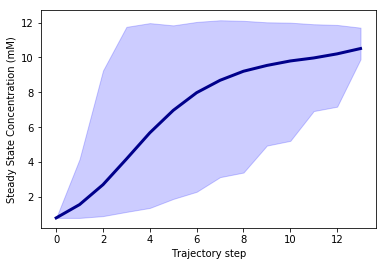

In [73]:
# Plot 95% probability density envelope and mean trajectory for delphindin

sns.lineplot(antho_traj.index, antho_traj["del_mean"], linewidth=3, color="darkblue")

#plt.fill_between(antho_traj.index, antho_traj["del_mean"] - 2*antho_traj["del_stdv"], antho_traj["del_mean"] + 2*antho_traj["del_stdv"],
                 #color='darkblue', alpha=0.3)
plt.fill_between(antho_traj.index, antho_traj["del_min"], antho_traj["del_max"],
                 color='blue', alpha=0.2) #actually want overall max trajectory!


plt.xlabel("Trajectory step")
plt.ylabel("Steady State Concentration (mM)");
#plt.savefig("mean-del-fill-plot.pdf", format="pdf")

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



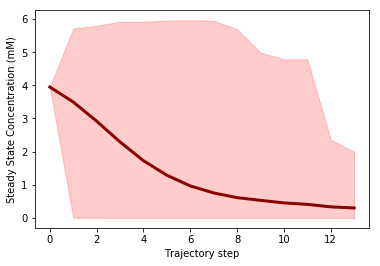

In [74]:
# Plot 95% probability density envelope and mean trajectory for pelargonidin
sns.lineplot(antho_traj.index, antho_traj["pel_mean"], linewidth=3, color="darkred")

plt.fill_between(antho_traj.index, antho_traj["pel_min"], antho_traj["pel_max"],
                 color='red', alpha=0.2) #actually want overall max trajectory!


plt.xlabel("Trajectory step")
plt.ylabel("Steady State Concentration (mM)");
#plt.savefig("mean-pel-fill-plot.pdf", format="pdf")

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



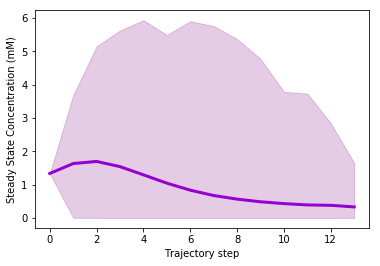

In [75]:
# Plot 95% probability density envelope and mean trajectory for cyanidin
sns.lineplot(antho_traj.index, antho_traj["cya_mean"], linewidth=3, color="darkviolet")

plt.fill_between(antho_traj.index, antho_traj["cya_min"], antho_traj["cya_max"],
                 color='purple', alpha=0.2) #actually want overall max trajectory!

plt.xlabel("Trajectory step")
plt.ylabel("Steady State Concentration (mM)");
#plt.savefig("mean-cya-fill-plot.pdf", format="pdf")

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



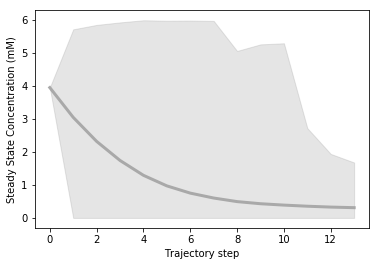

In [76]:
# Plot 95% probability density envelope and mean trajectory for kampferol
sns.lineplot(antho_traj.index, antho_traj["kam_mean"], linewidth=3, color="darkgray")

plt.fill_between(antho_traj.index, antho_traj["kam_min"], antho_traj["kam_max"],
                 color='gray', alpha=0.2) #actually want overall max trajectory!

plt.xlabel("Trajectory step")
plt.ylabel("Steady State Concentration (mM)");
#plt.savefig("mean-kam-fill-plot.pdf", format="pdf")

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



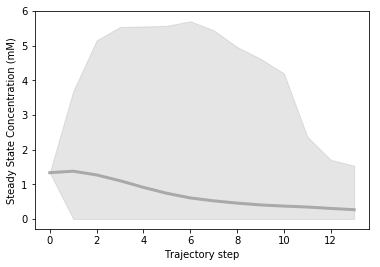

In [77]:
# Plot 95% probability density envelope and mean trajectory for quercetin
sns.lineplot(antho_traj.index, antho_traj["que_mean"], linewidth=3, color="darkgray")

plt.fill_between(antho_traj.index, antho_traj["que_min"], antho_traj["que_max"],
                 color='gray', alpha=0.2) #actually want overall max trajectory!

plt.xlabel("Trajectory step")
plt.ylabel("Steady State Concentration (mM)");
#plt.savefig("mean-que-fill-plot.pdf", format="pdf")

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



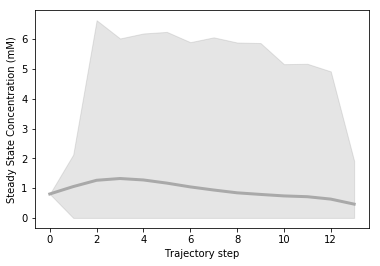

In [78]:
# Plot 95% probability density envelope and mean trajectory for myricetin
sns.lineplot(antho_traj.index, antho_traj["myr_mean"], linewidth=3, color="darkgray")

plt.fill_between(antho_traj.index, antho_traj["myr_min"], antho_traj["myr_max"],
                 color='gray', alpha=0.2) #actually want overall max trajectory!

plt.xlabel("Trajectory step")
plt.ylabel("Steady State Concentration (mM)");
#plt.savefig("mean-myr-fill-plot.pdf", format="pdf")

## Distribution of parameter values at optima (end states)

In [ ]:
# Need to iterate over all the simulations and collect the values for each parameter into a single list as 
# value in dict() with parameter name as key. Then can convert to pd.DataFrame. 

In [11]:
param_ids = list(r.getGlobalParameterIds())
param_ids = param_ids[0:-6]
print(param_ids)

['k_CHS_PCoA', 'CHSt', 'Km_CHS_PCoA', 'k_CHI_cha', 'CHIt', 'Km_CHI_cha', 'k_F3H_nar', 'F3Ht', 'Km_F3H_nar', 'k_F3pH_DHK', 'F3pHt', 'Km_F3pH_DHK', 'k_F35H_DHQ', 'F35Ht', 'Km_F35H_DHQ', 'k_FLS_DHK', 'FLSt', 'Km_FLS_DHK', 'Km_FLS_DHQ', 'Km_FLS_DHM', 'k_FLS_DHQ', 'k_FLS_DHM', 'k_DFR_DHK', 'DFRt', 'Km_DFR_DHK', 'Km_DFR_DHQ', 'Km_DFR_DHM', 'k_DFR_DHQ', 'k_DFR_DHM', 'k_ANS_LCP', 'ANSt', 'Km_ANS_LCP', 'Km_ANS_LCC', 'Km_ANS_LCD', 'k_ANS_LCC', 'k_ANS_LCD']


In [12]:
param_vals = []
for key in dataset.pathway_set.keys():
    vals = list(dataset.pathway_set[key].optima.values())
    if len(vals) > 0:# and len(dataset.pathway_set[key].concentrations) <= 54: 
        param_vals.append(vals[0][1][0:-6])

In [13]:
param_vals = np.array(param_vals)
param_vals = pd.DataFrame(param_vals)

In [14]:
param_vals.columns = param_ids

In [15]:
param_vals

,k_CHS_PCoA,CHSt,Km_CHS_PCoA,k_CHI_cha,CHIt,Km_CHI_cha,k_F3H_nar,F3Ht,Km_F3H_nar,k_F3pH_DHK,...,Km_DFR_DHM,k_DFR_DHQ,k_DFR_DHM,k_ANS_LCP,ANSt,Km_ANS_LCP,Km_ANS_LCC,Km_ANS_LCD,k_ANS_LCC,k_ANS_LCD
0,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,14.000000,...,0.013000,14.000000,14.000000,14.0,0.001,0.013,0.013,0.013,14.0,14.000000
1,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,42.886444,...,0.013000,14.000000,85.921980,14.0,0.001,0.013,0.013,0.013,14.0,14.000000
2,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,14.000000,...,0.013000,14.000000,14.000000,14.0,0.001,0.013,0.013,0.013,14.0,14.000000
3,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,42.422411,...,0.013000,14.000000,14.000000,14.0,0.001,0.013,0.013,0.013,14.0,14.000000
4,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,14.000000,...,0.013000,14.000000,14.000000,14.0,0.001,0.013,0.013,0.013,14.0,14.000000
5,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,53.710981,...,0.005712,7.478530,14.000000,14.0,0.001,0.013,0.013,0.013,14.0,14.000000
6,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,65.078723,...,0.013000,14.000000,82.720932,14.0,0.001,0.013,0.013,0.013,14.0,14.000000
7,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,104.816090,...,0.013000,14.000000,14.000000,14.0,0.001,0.013,0.013,0.013,14.0,14.000000
8,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,33.608237,...,0.013000,14.000000,14.000000,14.0,0.001,0.013,0.013,0.013,14.0,14.000000
9,14.0,0.001,0.013,14.0,0.001000,0.013,14.0,0.001,0.013,455.734460,...,0.013000,14.000000,14.000000,14.0,0.001,0.013,0.013,0.013,14.0,14.000000


### This is if I want to rescale the shifts to log10 fold changes
starting_params = list(r.getGlobalParameterValues())[0:-6]
starting_params

### This will calculate log10 fold changes for the shifts relative to starting parameters
param_vals = param_vals/starting_params
param_vals = param_vals.apply(np.log10)
param_vals

In [16]:
# Subset the optimal parameter values by parameter type (i.e. Et, kcat, Km)
conc_df = param_vals[[c for c in param_vals.columns if "t" in c]]
Km_df = param_vals[[c for c in param_vals.columns if "Km" in c]]
kcat_df = param_vals[[c for c in param_vals.columns if "k_" in c]]

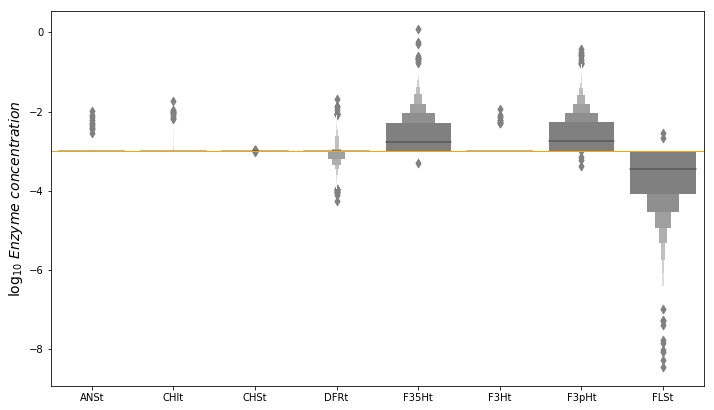

In [22]:
# Plot a matrix of correlations
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

cdf = conc_df.reindex(sorted(conc_df.columns), axis=1)
cdf = cdf.apply(np.log10)

sns.boxenplot(data=cdf, color="gray")

plt.axhline(y=np.log10(0.001), xmin=-1, xmax=8, linewidth=1, color="Orange"); 
plt.ylabel("$\log_{10}$ $Enzyme$ $concentration$", fontsize=14);
plt.gcf().subplots_adjust(bottom=0.25)
#plt.savefig("Et-optima-distributions.pdf", format="pdf")

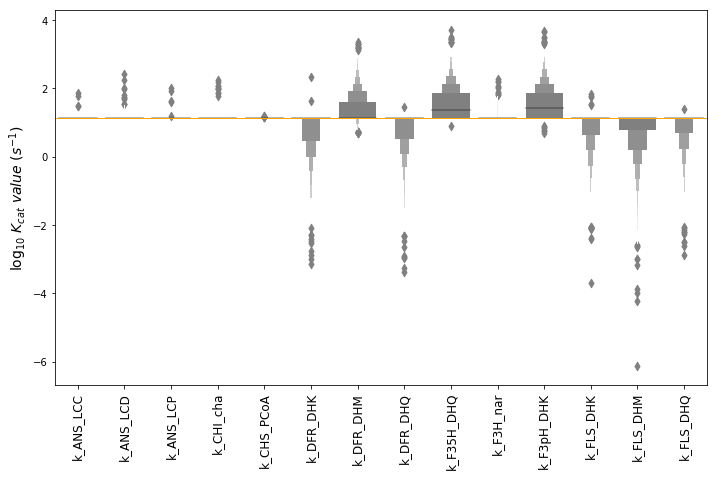

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

kcdf = kcat_df.reindex(sorted(kcat_df.columns), axis=1)
kcdf = kcdf.apply(np.log10)

sns.boxenplot(data=kcdf, color="gray")

plt.axhline(y=np.log10(14), xmin=-1, xmax=14, linewidth=1, color="orange");
plt.xticks(rotation=90, fontsize=12);
plt.ylabel(r"$\log_{10}$ $K_{cat}$ $value$ $(s^{-1})$", fontsize=14);
plt.gcf().subplots_adjust(bottom=0.25);
#plt.savefig("kcat-optima-distributions.pdf", format="pdf")

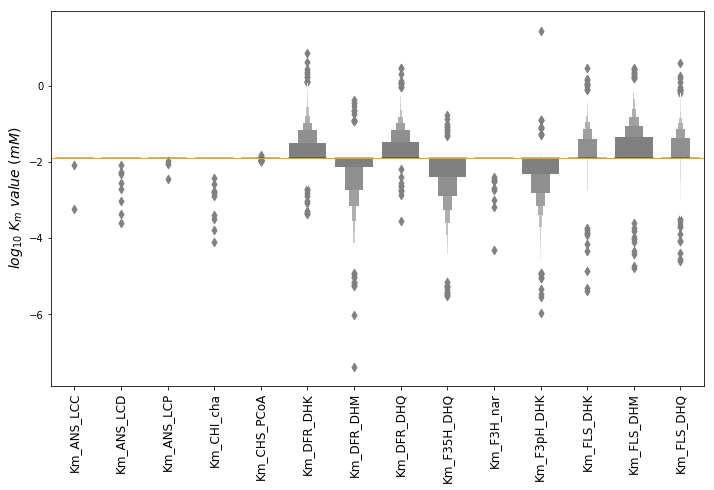

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

kmdf = Km_df.reindex(sorted(Km_df.columns), axis=1)
kmdf = kmdf.apply(np.log10)

sns.boxenplot(data=kmdf, color="gray")

plt.axhline(y=np.log10(0.013), xmin=-1, xmax=14, linewidth=1, color="Orange");
plt.xticks(rotation=90, fontsize=12);
plt.ylabel("$log_{10}$ $K_{m}$ $value$ $(mM)$", fontsize=14);
plt.gcf().subplots_adjust(bottom=0.25);
#plt.savefig("Km-optima-distributions.pdf", format="pdf")

### This is for the rescaling to log10 fold changes

throwaway = []

for col in param_vals.columns:
    if "CHS" in col or "CHI" in col or "F3H" in col or "ANS" in col:
        throwaway.append(col)
        
throwaway

param_vals_trunc = param_vals.drop(throwaway, axis=1)

fig, ax = plt.subplots()
fig.set_size_inches(22, 16)

param_vals_trunc = param_vals_trunc.reindex(sorted(param_vals_trunc.columns), axis=1)
#kmdf = kmdf.apply(np.log10)


sns.boxenplot(data=param_vals_trunc, color="gray", orient="h")
#plt.ylim(-0.01, 0.25)
plt.axvline(x=0.0, ymin=-1, ymax=14, linewidth=1, color="Orange");
plt.xticks(rotation=360, fontsize=18);
plt.xlabel("$log_{10}$ $fold$ $change$", fontsize=18);
plt.gcf().subplots_adjust(bottom=0.25);
#plt.savefig("parameter-log-fold-change.pdf", format="pdf")

## Control coefficients and elasticities at optimal states
Looking at the median shifts going from starting state to optima. Possibly might want to try to look at a) distributions of CCs for each reaction/species pair, and b) *typical* rather than median sets of CCs. Could lso consider calculating a difference heatmap. i.e. change going from starting state to median. 

In [88]:
# Need to get control coefficient matrix from all simulations with successful mca then build a list of CC values
# for each reaction (linearize the matrices). Can then construct distributions for each CC at end states/optima.
all_cc_matrices = []
all_e_matrices = []

# Iterate over all the Pathway objects, check to make sure there were no numerical errors flagged, 
# check to make sure that the simulation reached an optimum state, grab the desired columns (exclude "sinks")
for key in dataset.pathway_set.keys():
    if not hasattr(dataset.pathway_set[key], 'mca_error') and len(dataset.pathway_set[key].optima) > 0: 
        ccdf = deepcopy(dataset.pathway_set[key].cc_matrix)
        ccdf = ccdf.drop(columns=["Source","pel_sink", "cya_sink", "del_sink", "kam_sink", "que_sink", "myr_sink"])
        
        edf = deepcopy(dataset.pathway_set[key].elasticities)
        edf.drop(["Source", "kam_sink", "myr_sink", "que_sink", "pel_sink", "cya_sink", "del_sink"], inplace = True)
        
        all_cc_matrices.append(ccdf)
        all_e_matrices.append(edf)
        
    else:
        print(key)
        pass 

267
853
917
3266
5203
5971
6001
6640
6672
7198
7539
8615
9396
9842
9880


In [89]:
cc_index = list(CC_df.index.values)
print(cc_index)

e_index = list(EC_df.index.values)
print(e_index)

['cha', 'nar', 'DHK', 'DHQ', 'DHM', 'kam', 'que', 'myr', 'LCP', 'LCC', 'LCD', 'pel', 'cya', 'del']
['CHS', 'CHI', 'F3H_nar', 'F3pH_DHK', 'F35H_DHQ', 'FLS_DHK', 'FLS_DHQ', 'FLS_DHM', 'DFR_DHK', 'DFR_DHQ', 'DFR_DHM', 'ANS_LCP', 'ANS_LCC', 'ANS_LCD']


In [90]:
median_cc_matrix = pd.concat(all_cc_matrices).groupby(level=0).median()
median_cc_matrix = median_cc_matrix.reindex(cc_index)
median_cc_matrix

,CHS,CHI,F3H_nar,F3pH_DHK,F35H_DHQ,FLS_DHK,FLS_DHQ,FLS_DHM,DFR_DHK,DFR_DHQ,DFR_DHM,ANS_LCP,ANS_LCC,ANS_LCD
cha,1.769232,-1.769232,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nar,1.769232,0.000000,-1.769232,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DHK,1.098123,0.000000,0.000000,-1.015380,-1.277248e-04,-0.011733,-0.000122,-0.000368,-0.029189,-0.000344,-0.013511,0.000000,0.000000,0.000000
DHQ,1.120090,0.000000,0.000000,0.055727,-1.015759e+00,-0.012131,-0.011686,-0.000938,-0.029768,-0.028907,-0.036667,0.000000,0.000000,0.000000
DHM,1.681923,0.000000,0.000000,0.040820,3.996509e-02,-0.016445,-0.015242,-0.050160,-0.040326,-0.038541,-1.537108,0.000000,0.000000,0.000000
kam,0.873610,0.000000,0.000000,-0.994050,1.169115e-02,0.993029,0.001419,0.003431,-0.016024,0.003889,0.109370,0.000000,0.000000,0.000000
que,0.884864,0.000000,0.000000,0.077627,-9.956557e-01,-0.006873,0.992235,0.002951,-0.016418,-0.018547,0.091269,0.000000,0.000000,0.000000
myr,1.097124,0.000000,0.000000,0.059851,5.844085e-02,-0.012030,-0.011850,0.959366,-0.029256,-0.029160,-1.095281,0.000000,0.000000,0.000000
LCP,1.148250,0.000000,0.000000,-0.997107,8.290990e-04,-0.011586,-0.000238,-0.001119,0.989184,0.011080,0.567330,-1.018193,-0.016695,-0.620087
LCC,1.176707,0.000000,0.000000,0.070331,-9.999032e-01,-0.011732,-0.011835,-0.002333,-0.011430,0.986843,0.536981,-0.018193,-1.016695,-0.620087


In [91]:
median_e_matrix = pd.concat(all_e_matrices).groupby(level=0).median()
median_e_matrix = median_e_matrix.reindex(EC_df.index)
median_e_matrix

,cha,nar,DHK,DHQ,DHM,kam,que,myr,LCP,LCC,LCD,pel,cya,del
CHS,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
CHI,0.565217,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
F3H_nar,0.000000,0.565217,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
F3pH_DHK,0.000000,0.000000,0.933573,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
F35H_DHQ,0.000000,0.000000,0.000000,0.935655,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
FLS_DHK,0.000000,0.000000,0.978338,-0.019229,-0.089325,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
FLS_DHQ,0.000000,0.000000,-0.021662,0.980771,-0.089325,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
FLS_DHM,0.000000,0.000000,-0.021662,-0.019229,0.910675,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
DFR_DHK,0.000000,0.000000,0.984085,-0.014143,-0.361510,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
DFR_DHQ,0.000000,0.000000,-0.015915,0.985857,-0.361510,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [92]:
# Need to change this to somehow show absolute magnitude and difference. Sebastian suggested a log plot?

# Calculate difference matrices (median matrix - starting matrix)
cc_difference = median_cc_matrix.subtract(CC_df)
e_difference = median_e_matrix.subtract(EC_df)

#cc_difference = CC_df.subtract(median_cc_matrix)
#e_difference = EC_df.subtract(median_e_matrix)

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



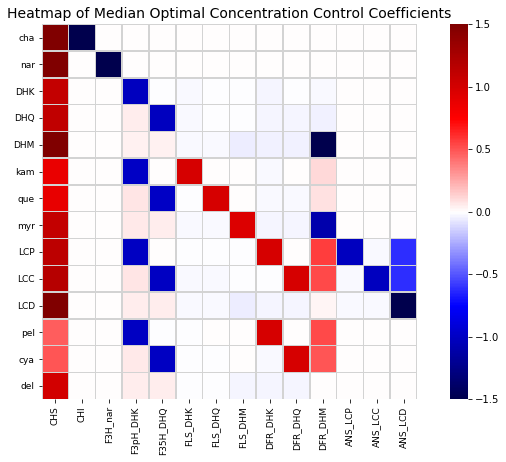

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(median_cc_matrix, square=True, linewidths=0.5, cmap="seismic", linecolor="lightgray", vmax=1.5, vmin=-1.5)

plt.gcf().subplots_adjust(bottom=0.25)
#plt.rcParams["font.family"] = "georgia"

plt.title("Heatmap of Median Optimal Concentration Control Coefficients", fontsize=14);
ax.tick_params(axis='both', which='both', labelsize=9)
plt.yticks(rotation=-360);

#plt.savefig("median-optimal-control-coefficients-heatmap.pdf", format="pdf")

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



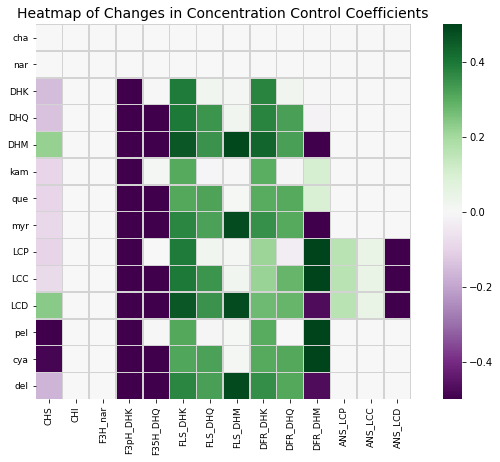

In [94]:
# Maybe take the Log first and then subtract? 

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(cc_difference, square=True, linewidths=0.5, cmap="PRGn", linecolor="lightgray", vmin=-0.5, vmax=0.5)

plt.gcf().subplots_adjust(bottom=0.25)
#plt.rcParams["font.family"] = "georgia"

plt.title("Heatmap of Changes in Concentration Control Coefficients", fontsize=14);
ax.tick_params(axis='both', which='both', labelsize=9)
plt.yticks(rotation=-360);

#plt.savefig("delta-control-coefficients-heatmap.pdf", format="pdf")

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



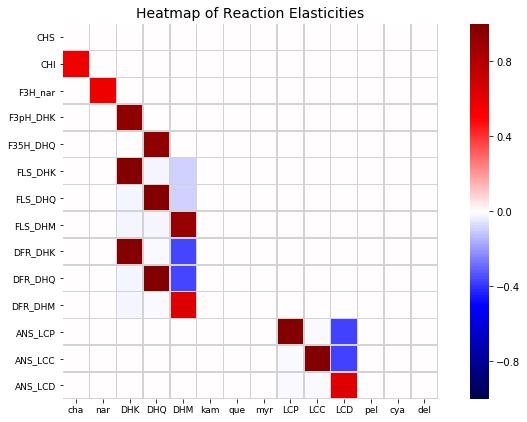

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(median_e_matrix, square=True, linewidths=0.5, cmap="seismic", linecolor="lightgray", vmax=1, vmin=-1)

plt.gcf().subplots_adjust(bottom=0.25)
#plt.rcParams["font.family"] = "georgia"

plt.title("Heatmap of Reaction Elasticities", fontsize=14);
ax.tick_params(axis='both', which='both', labelsize=9)

#plt.savefig("median-optimal-elasticities-heatmap.pdf", format="pdf")

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



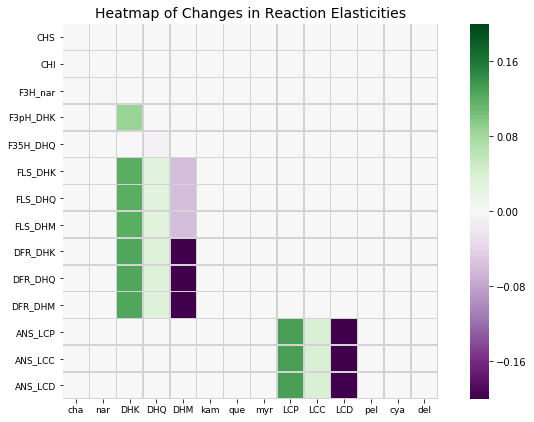

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(e_difference, square=True, linewidths=0.5, cmap="PRGn", linecolor="lightgray", vmin=-0.2, vmax=0.2)

plt.gcf().subplots_adjust(bottom=0.25)
#plt.rcParams["font.family"] = "georgia"

plt.title("Heatmap of Changes in Reaction Elasticities", fontsize=14);
ax.tick_params(axis='both', which='both', labelsize=9)

#plt.savefig("delta-elasticities-heatmap.pdf", format="pdf")

## Correlations between parameters across trajectories
Examining how *fixed* parameter changes are correlated across all trajectories to highlight constraints placed on the evolving pathway system. Pairwise correlations between parameters will indicate the degree to which parameters can limit or facilitate evolution. 

In [ ]:
# To do this need to reconstruct parameter values at each step, based on starting point and the fixation
# log that I keep (parameters attribute of Pathway object).

In [198]:
param_ids = list(r.getGlobalParameterIds())
param_ids = param_ids[0:-6]
print(param_ids)

['k_CHS_PCoA', 'CHSt', 'Km_CHS_PCoA', 'k_CHI_cha', 'CHIt', 'Km_CHI_cha', 'k_F3H_nar', 'F3Ht', 'Km_F3H_nar', 'k_F3pH_DHK', 'F3pHt', 'Km_F3pH_DHK', 'k_F35H_DHQ', 'F35Ht', 'Km_F35H_DHQ', 'k_FLS_DHK', 'FLSt', 'Km_FLS_DHK', 'Km_FLS_DHQ', 'Km_FLS_DHM', 'k_FLS_DHQ', 'k_FLS_DHM', 'k_DFR_DHK', 'DFRt', 'Km_DFR_DHK', 'Km_DFR_DHQ', 'Km_DFR_DHM', 'k_DFR_DHQ', 'k_DFR_DHM', 'k_ANS_LCP', 'ANSt', 'Km_ANS_LCP', 'Km_ANS_LCC', 'Km_ANS_LCD', 'k_ANS_LCC', 'k_ANS_LCD']


In [199]:
initial_params = list(r.getGlobalParameterValues())
initial_params = initial_params[0:-6]
print(initial_params)

[14.0, 0.001, 0.013, 14.0, 0.001, 0.013, 14.0, 0.001, 0.013, 14.0, 0.001, 0.013, 14.0, 0.001, 0.013, 14.0, 0.001, 0.013, 0.013, 0.013, 14.0, 14.0, 14.0, 0.001, 0.013, 0.013, 0.013, 14.0, 14.0, 14.0, 0.001, 0.013, 0.013, 0.013, 14.0, 14.0]


In [200]:
param_start = {}
for i in range(len(param_ids)):
    param_start[param_ids[i]] = [initial_params[i]]

In [201]:
print(param_start)

{'k_CHS_PCoA': [14.0], 'CHSt': [0.001], 'Km_CHS_PCoA': [0.013], 'k_CHI_cha': [14.0], 'CHIt': [0.001], 'Km_CHI_cha': [0.013], 'k_F3H_nar': [14.0], 'F3Ht': [0.001], 'Km_F3H_nar': [0.013], 'k_F3pH_DHK': [14.0], 'F3pHt': [0.001], 'Km_F3pH_DHK': [0.013], 'k_F35H_DHQ': [14.0], 'F35Ht': [0.001], 'Km_F35H_DHQ': [0.013], 'k_FLS_DHK': [14.0], 'FLSt': [0.001], 'Km_FLS_DHK': [0.013], 'Km_FLS_DHQ': [0.013], 'Km_FLS_DHM': [0.013], 'k_FLS_DHQ': [14.0], 'k_FLS_DHM': [14.0], 'k_DFR_DHK': [14.0], 'DFRt': [0.001], 'Km_DFR_DHK': [0.013], 'Km_DFR_DHQ': [0.013], 'Km_DFR_DHM': [0.013], 'k_DFR_DHQ': [14.0], 'k_DFR_DHM': [14.0], 'k_ANS_LCP': [14.0], 'ANSt': [0.001], 'Km_ANS_LCP': [0.013], 'Km_ANS_LCC': [0.013], 'Km_ANS_LCD': [0.013], 'k_ANS_LCC': [14.0], 'k_ANS_LCD': [14.0]}


In [202]:
# Generate an unmuated set of all parameters trajectories
full_set = []

for i in range(len(dataset.pathway_set.keys())):
    mutant_params = deepcopy(param_start)
    
    for key in mutant_params.keys():
        mutant_params[key] = mutant_params[key]*len(dataset.pathway_set[i].parameters)
        
    full_set.append(mutant_params)

In [203]:
# Iterate over the simulations and introduce the fixed mutations into each set of parameters
# at all points where there has actually been a change. Unmutated points remain the same. 
for i in range(len(full_set)):
    for j in range(len(dataset.pathway_set[i].parameters)):
        full_set[i][dataset.pathway_set[i].parameters[j][0]][j:] = [dataset.pathway_set[i].parameters[j][1] for n in range(len(full_set[i][dataset.pathway_set[i].parameters[j][0]][j:]))]
     
    full_set[i] = pd.DataFrame(full_set[i])
    #full_set[i].iloc[-1] = initial_params
    #full_set[i].index = full_set[i].index + 1  # shifting index
    #full_set[i].sort_index(inplace=True)

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



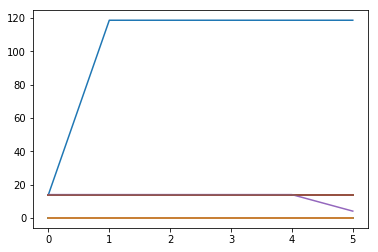

In [204]:
full_set[0].plot(legend=False)

In [205]:
full_set[0]

,ANSt,CHIt,CHSt,DFRt,F35Ht,F3Ht,F3pHt,FLSt,Km_ANS_LCC,Km_ANS_LCD,...,k_CHS_PCoA,k_DFR_DHK,k_DFR_DHM,k_DFR_DHQ,k_F35H_DHQ,k_F3H_nar,k_F3pH_DHK,k_FLS_DHK,k_FLS_DHM,k_FLS_DHQ
0,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,0.000418,0.013,0.013,...,14.0,14.0,14.0,14.0,14.000000,14.0,14.0,14.0,14.0,14.0
1,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,0.000418,0.013,0.013,...,14.0,14.0,14.0,14.0,14.000000,14.0,14.0,14.0,14.0,14.0
2,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,0.000043,0.013,0.013,...,14.0,14.0,14.0,14.0,14.000000,14.0,14.0,14.0,14.0,14.0
3,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,0.000043,0.013,0.013,...,14.0,14.0,14.0,14.0,20.072513,14.0,14.0,14.0,14.0,14.0
4,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,0.000043,0.013,0.013,...,14.0,14.0,14.0,14.0,20.072513,14.0,14.0,14.0,14.0,14.0
5,0.001,0.001,0.001,0.001,0.002044,0.001,0.001,0.000043,0.013,0.013,...,14.0,14.0,14.0,14.0,20.072513,14.0,14.0,14.0,14.0,14.0
6,0.001,0.001,0.001,0.001,0.002044,0.001,0.001,0.000043,0.013,0.013,...,14.0,14.0,14.0,14.0,20.072513,14.0,14.0,14.0,14.0,14.0
7,0.001,0.001,0.001,0.001,0.002044,0.001,0.001,0.000043,0.013,0.013,...,14.0,14.0,14.0,14.0,61.274405,14.0,14.0,14.0,14.0,14.0
8,0.001,0.001,0.001,0.001,0.002044,0.001,0.001,0.000013,0.013,0.013,...,14.0,14.0,14.0,14.0,61.274405,14.0,14.0,14.0,14.0,14.0
9,0.001,0.001,0.001,0.001,0.002044,0.001,0.001,0.000013,0.013,0.013,...,14.0,14.0,14.0,14.0,61.274405,14.0,14.0,14.0,14.0,14.0


In [206]:
p_col_names = list(full_set[0].columns)
p_col_names = [p for p in p_col_names if 'DFR' not in p and 'FLS' not in p and 'F3pH' not in p 
               and 'F35H' not in p]
print(p_col_names)

['ANSt', 'CHIt', 'CHSt', 'F3Ht', 'Km_ANS_LCC', 'Km_ANS_LCD', 'Km_ANS_LCP', 'Km_CHI_cha', 'Km_CHS_PCoA', 'Km_F3H_nar', 'k_ANS_LCC', 'k_ANS_LCD', 'k_ANS_LCP', 'k_CHI_cha', 'k_CHS_PCoA', 'k_F3H_nar']


In [207]:
# This is just to remove the columns for parameters that don't contribute substantially to trajectories. 
for f in full_set:
    f = f.drop(p_col_names, axis = 1, inplace = True)

In [208]:
# This is for taking the inverse of the Km, because that makes it easier to look at!
for f in full_set:
    for cc in f.columns:
        if "Km" in cc:
            f[cc] = 1/f[cc]

In [210]:
full_set[0]

,DFRt,F35Ht,F3pHt,FLSt,Km_DFR_DHK,Km_DFR_DHM,Km_DFR_DHQ,Km_F35H_DHQ,Km_F3pH_DHK,Km_FLS_DHK,Km_FLS_DHM,Km_FLS_DHQ,k_DFR_DHK,k_DFR_DHM,k_DFR_DHQ,k_F35H_DHQ,k_F3pH_DHK,k_FLS_DHK,k_FLS_DHM,k_FLS_DHQ
0,0.001,0.001000,0.001,0.000418,76.923077,76.923077,76.923077,76.923077,76.923077,76.923077,76.923077,76.923077,14.0,14.0,14.0,14.000000,14.0,14.0,14.0,14.0
1,0.001,0.001000,0.001,0.000418,76.923077,76.923077,23.987155,76.923077,76.923077,76.923077,76.923077,76.923077,14.0,14.0,14.0,14.000000,14.0,14.0,14.0,14.0
2,0.001,0.001000,0.001,0.000043,76.923077,76.923077,23.987155,76.923077,76.923077,76.923077,76.923077,76.923077,14.0,14.0,14.0,14.000000,14.0,14.0,14.0,14.0
3,0.001,0.001000,0.001,0.000043,76.923077,76.923077,23.987155,76.923077,76.923077,76.923077,76.923077,76.923077,14.0,14.0,14.0,20.072513,14.0,14.0,14.0,14.0
4,0.001,0.001000,0.001,0.000043,24.022186,76.923077,23.987155,76.923077,76.923077,76.923077,76.923077,76.923077,14.0,14.0,14.0,20.072513,14.0,14.0,14.0,14.0
5,0.001,0.002044,0.001,0.000043,24.022186,76.923077,23.987155,76.923077,76.923077,76.923077,76.923077,76.923077,14.0,14.0,14.0,20.072513,14.0,14.0,14.0,14.0
6,0.001,0.002044,0.001,0.000043,24.022186,76.923077,23.987155,76.923077,76.923077,33.300841,76.923077,76.923077,14.0,14.0,14.0,20.072513,14.0,14.0,14.0,14.0
7,0.001,0.002044,0.001,0.000043,24.022186,76.923077,23.987155,76.923077,76.923077,33.300841,76.923077,76.923077,14.0,14.0,14.0,61.274405,14.0,14.0,14.0,14.0
8,0.001,0.002044,0.001,0.000013,24.022186,76.923077,23.987155,76.923077,76.923077,33.300841,76.923077,76.923077,14.0,14.0,14.0,61.274405,14.0,14.0,14.0,14.0
9,0.001,0.002044,0.001,0.000013,24.022186,76.923077,23.987155,76.923077,1147.578653,33.300841,76.923077,76.923077,14.0,14.0,14.0,61.274405,14.0,14.0,14.0,14.0


In [211]:
PC = []
for i in range(len(full_set)):
    pc = full_set[i].corr(method="spearman")
    PC.append(pc)
PC = pd.concat(PC)

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



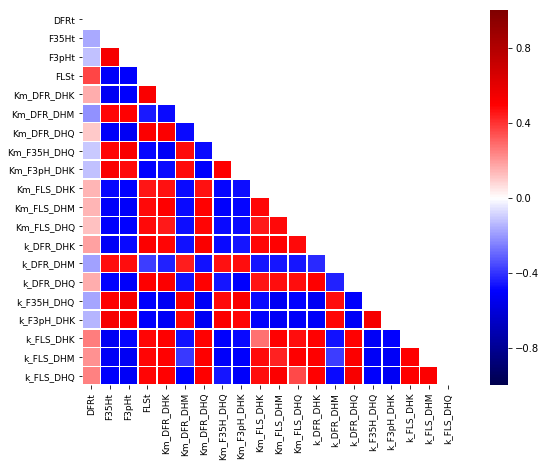

In [212]:
# This will be a figure included in the paper, showing overall floating species correlations
by_row_index = PC.groupby(PC.index)
PC_means = by_row_index.mean()


#CC_means = CC_means.round(decimals=2)

# Generate a mask for the upper triangle
mask = np.zeros_like(PC_means, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot a matrix of correlations
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.heatmap(PC_means, mask=mask, square=True, linewidths=0.5, linecolor="white", cmap="seismic", vmin=-1, vmax=1)
#sns.heatmap(PC_means, mask=mask, square=True, linewidths=0.5, cmap="seismic")

plt.gcf().subplots_adjust(bottom=0.25)
ax.tick_params(axis='both', which='both', labelsize=9)


plt.xticks(rotation=90)
plt.yticks(rotation=-360);

#plt.savefig("parameters-subset-spearman-correlations-inverseKm.pdf", format="pdf")

In [112]:
PC_means

,DFRt,F35Ht,F3pHt,FLSt,Km_DFR_DHK,Km_DFR_DHM,Km_DFR_DHQ,Km_F35H_DHQ,Km_F3pH_DHK,Km_FLS_DHK,Km_FLS_DHM,Km_FLS_DHQ,k_DFR_DHK,k_DFR_DHM,k_DFR_DHQ,k_F35H_DHQ,k_F3pH_DHK,k_FLS_DHK,k_FLS_DHM,k_FLS_DHQ
DFRt,1.000000,-0.170612,-0.118785,0.365656,-0.161998,0.211177,-0.107834,0.102607,0.121876,-0.140965,-0.142740,-0.123906,0.181526,-0.185684,0.160950,-0.172290,-0.143621,0.252769,0.215781,0.249747
F35Ht,-0.170612,1.000000,0.531531,-0.508107,0.523739,-0.488142,0.511048,-0.489024,-0.518373,0.487871,0.508566,0.503693,-0.519603,0.470592,-0.493440,0.503015,0.537470,-0.530158,-0.520272,-0.507476
F3pHt,-0.118785,0.531531,1.000000,-0.504714,0.504220,-0.494462,0.525793,-0.521531,-0.481725,0.496777,0.509038,0.496648,-0.482841,0.472418,-0.512417,0.537158,0.508146,-0.491651,-0.523623,-0.519837
FLSt,0.365656,-0.508107,-0.504714,1.000000,-0.515641,0.450517,-0.507836,0.487784,0.497484,-0.455583,-0.481226,-0.478926,0.508185,-0.381272,0.504665,-0.506050,-0.505055,0.487102,0.491220,0.486368
Km_DFR_DHK,-0.161998,0.523739,0.504220,-0.515641,1.000000,-0.481451,0.509181,-0.519186,-0.483259,0.466766,0.501960,0.448762,-0.491330,0.436142,-0.510738,0.523617,0.516697,-0.502574,-0.498638,-0.495089
Km_DFR_DHM,0.211177,-0.488142,-0.494462,0.450517,-0.481451,1.000000,-0.478712,0.479568,0.479083,-0.479374,-0.481772,-0.476087,0.462316,-0.437673,0.466935,-0.508432,-0.492177,0.465119,0.388191,0.492350
Km_DFR_DHQ,-0.107834,0.511048,0.525793,-0.507836,0.509181,-0.478712,1.000000,-0.482941,-0.503384,0.468355,0.495929,0.485301,-0.517848,0.461556,-0.493343,0.522021,0.527960,-0.497373,-0.502847,-0.507066
Km_F35H_DHQ,0.102607,-0.489024,-0.521531,0.487784,-0.519186,0.479568,-0.482941,1.000000,0.500068,-0.484647,-0.500121,-0.482291,0.479092,-0.466839,0.460814,-0.481326,-0.511784,0.502166,0.512494,0.457404
Km_F3pH_DHK,0.121876,-0.518373,-0.481725,0.497484,-0.483259,0.479083,-0.503384,0.500068,1.000000,-0.476258,-0.490872,-0.483837,0.457298,-0.472455,0.501663,-0.515919,-0.486427,0.482443,0.501032,0.509489
Km_FLS_DHK,-0.140965,0.487871,0.496777,-0.455583,0.466766,-0.479374,0.468355,-0.484647,-0.476258,1.000000,0.486398,0.446664,-0.487191,0.458476,-0.454697,0.483525,0.505514,-0.275065,-0.481643,-0.468939


## Mean optimal parameter values model with simulations
Construct a model with mean optimal parameter values from optima distributions and simulate ouput. Looks like the mean values just recapitulate the starting state! 

In [124]:
param_means = dict(param_vals.mean())

In [125]:
param_means

{'ANSt': 0.001005979750847378,
 'CHIt': 0.0010153569946240264,
 'CHSt': 0.0010000668079728397,
 'DFRt': 0.0010196799575901176,
 'F35Ht': 0.005454101977829488,
 'F3Ht': 0.0010108817607236032,
 'F3pHt': 0.005268439509705627,
 'FLSt': 0.0004988220423840435,
 'Km_ANS_LCC': 0.012998289667036846,
 'Km_ANS_LCD': 0.012992131385624458,
 'Km_ANS_LCP': 0.01299846203091979,
 'Km_CHI_cha': 0.01298369112451587,
 'Km_CHS_PCoA': 0.012998490370575842,
 'Km_DFR_DHK': 0.03988078579287633,
 'Km_DFR_DHM': 0.010750791657183161,
 'Km_DFR_DHQ': 0.0366403118288918,
 'Km_F35H_DHQ': 0.009580508976819545,
 'Km_F3H_nar': 0.01298774525436856,
 'Km_F3pH_DHK': 0.012687453431983586,
 'Km_FLS_DHK': 0.026211987615284336,
 'Km_FLS_DHM': 0.05277918965618227,
 'Km_FLS_DHQ': 0.026025633429780873,
 'k_ANS_LCC': 14.013766104816712,
 'k_ANS_LCD': 14.087610014723307,
 'k_ANS_LCP': 14.021620052572143,
 'k_CHI_cha': 14.147317876799146,
 'k_CHS_PCoA': 14.000663936898455,
 'k_DFR_DHK': 11.579208950415481,
 'k_DFR_DHM': 45.149015024

In [126]:
rr = te.loada('''
    
    # Constant source entering model
    Source: => PCoA;
    
    # Rate laws for all the central enzymatic reactions
    
    CHS: PCoA => cha; (k_CHS_PCoA*CHSt*PCoA)/(Km_CHS_PCoA + PCoA);
    
    CHI: cha => nar; (k_CHI_cha*CHIt*cha)/(Km_CHI_cha + cha);
    

    F3H_nar: nar => DHK; (k_F3H_nar*F3Ht*nar)/(Km_F3H_nar + nar);
    
    
    F3pH_DHK: DHK => DHQ; (k_F3pH_DHK*F3pHt*DHK)/(Km_F3pH_DHK + DHK);
    
    
    F35H_DHQ: DHQ => DHM; (k_F35H_DHQ*F35Ht*DHQ)/(Km_F35H_DHQ + DHQ);
    
    
    FLS_DHK: DHK => kam; (k_FLS_DHK*FLSt*DHK)/(Km_FLS_DHK * (1 + DHQ/Km_FLS_DHQ + DHM/Km_FLS_DHM) + DHK);
    
    FLS_DHQ: DHQ => que; (k_FLS_DHQ*FLSt*DHQ)/(Km_FLS_DHQ * (1 + DHM/Km_FLS_DHM + DHK/Km_FLS_DHK) + DHQ);
    
    FLS_DHM: DHM => myr; (k_FLS_DHM*FLSt*DHM)/(Km_FLS_DHM * (1 + DHK/Km_FLS_DHK + DHQ/Km_FLS_DHQ) + DHM);
    
    
    DFR_DHK: DHK => LCP; (k_DFR_DHK*DFRt*DHK)/(Km_DFR_DHK * (1 + DHQ/Km_DFR_DHQ + DHM/Km_DFR_DHM) + DHK);
    
    DFR_DHQ: DHQ => LCC; (k_DFR_DHQ*DFRt*DHQ)/(Km_DFR_DHQ * (1 + DHK/Km_DFR_DHK + DHM/Km_DFR_DHM) + DHQ);
    
    DFR_DHM: DHM => LCD; (k_DFR_DHM*DFRt*DHM)/(Km_DFR_DHM * (1 + DHK/Km_DFR_DHK + DHQ/Km_DFR_DHQ) + DHM);
    
    
    ANS_LCP: LCP => pel; (k_ANS_LCP*ANSt*LCP)/(Km_ANS_LCP * (1 + LCC/Km_ANS_LCC + LCD/Km_ANS_LCD) + LCP);
    
    ANS_LCC: LCC => cya; (k_ANS_LCC*ANSt*LCC)/(Km_ANS_LCC * (1 + LCP/Km_ANS_LCP + LCD/Km_ANS_LCD) + LCC);
    
    ANS_LCD: LCD => del; (k_ANS_LCD*ANSt*LCD)/(Km_ANS_LCD * (1 + LCP/Km_ANS_LCP + LCC/Km_ANS_LCC) + LCD);
    

    # Product sinks
    
    pel_sink: pel =>; k_pel_sink*pel;
    
    cya_sink: cya =>; k_cya_sink*cya;
    
    del_sink: del =>; k_del_sink*del;
    

    kam_sink: kam =>; k_kam_sink*kam;
    
    que_sink: que =>; k_que_sink*que;
    
    myr_sink: myr =>; k_myr_sink*myr;
    
        
    # Substrate Kcat's
    k_CHS_PCoA=14; k_CHI_cha=14; k_F3H_nar=14; 
    k_F3pH_DHK=14; k_F35H_DHQ=14; k_FLS_DHK=14; 
    k_FLS_DHQ=14; k_FLS_DHM=14; k_DFR_DHK=14; k_DFR_DHQ=14; k_DFR_DHM=14; k_ANS_LCP=14; k_ANS_LCC=14;
    k_ANS_LCD=14; 
   
    # Substrate Km's
    Km_CHS_PCoA=0.013; Km_CHI_cha=0.013;  
    Km_F3H_nar=0.013; Km_F3pH_DHK=0.013; Km_F35H_DHQ=0.013; 
    Km_FLS_DHK=0.013; Km_FLS_DHQ=0.013; Km_FLS_DHM=0.013; 
    Km_DFR_DHK=0.013; Km_DFR_DHQ=0.013; Km_DFR_DHM=0.013;  
    Km_ANS_LCP=0.013; Km_ANS_LCC=0.013; Km_ANS_LCD=0.013;


    # Enzyme concentrations
    CHSt=0.001; CHIt=0.001; F3Ht=0.001; F3pHt=0.001;
    F35Ht=0.001; FLSt=0.001; DFRt=0.001; ANSt=0.001; 

    
    # Rates for sinks 
    k_pel_sink=0.0005; k_cya_sink=0.0005; k_del_sink=0.0005; 
    k_kam_sink=0.0005; k_que_sink=0.0005; k_myr_sink=0.0005; 
    
    # Source influx
    const PCoA = 0.01;
    #PCoA = 1000;
''')

for key in param_medians.keys():
    rr.setValue(id=key, value=param_means[key])

In [127]:
start_state_params = r.getGlobalParameterValues()
start_state_params = start_state_params[0:-6]
start_state_params

array([1.4e+01, 1.0e-03, 1.3e-02, 1.4e+01, 1.0e-03, 1.3e-02, 1.4e+01,
       1.0e-03, 1.3e-02, 1.4e+01, 1.0e-03, 1.3e-02, 1.4e+01, 1.0e-03,
       1.3e-02, 1.4e+01, 1.0e-03, 1.3e-02, 1.3e-02, 1.3e-02, 1.4e+01,
       1.4e+01, 1.4e+01, 1.0e-03, 1.3e-02, 1.3e-02, 1.3e-02, 1.4e+01,
       1.4e+01, 1.4e+01, 1.0e-03, 1.3e-02, 1.3e-02, 1.3e-02, 1.4e+01,
       1.4e+01])

In [128]:
mean_optimal_params = rr.getGlobalParameterValues()
mean_optimal_params = mean_optimal_params[0:-6]
mean_optimal_params

array([1.40006639e+01, 1.00006681e-03, 1.29984904e-02, 1.41473179e+01,
       1.01535699e-03, 1.29836911e-02, 1.41546600e+01, 1.01088176e-03,
       1.29877453e-02, 7.43690759e+01, 5.26843951e-03, 1.26874534e-02,
       7.44946700e+01, 5.45410198e-03, 9.58050898e-03, 1.21160758e+01,
       4.98822042e-04, 2.62119876e-02, 2.60256334e-02, 5.27791897e-02,
       1.21886580e+01, 1.06943914e+01, 1.15792090e+01, 1.01967996e-03,
       3.98807858e-02, 3.66403118e-02, 1.07507917e-02, 1.17145987e+01,
       4.51490150e+01, 1.40216201e+01, 1.00597975e-03, 1.29984620e-02,
       1.29982897e-02, 1.29921314e-02, 1.40137661e+01, 1.40876100e+01])

In [177]:
param_shifts = (mean_optimal_params - start_state_params)/start_state_params
param_shifts 

array([ 4.74240642e-05,  6.68079728e-05, -1.16125340e-04,  1.05227055e-02,
        1.53569946e-02, -1.25452888e-03,  1.10471420e-02,  1.08817607e-02,
       -9.42672741e-04,  4.31207685e+00,  4.26843951e+00, -2.40420437e-02,
        4.32104786e+00,  4.45410198e+00, -2.63037771e-01, -1.34566012e-01,
       -5.01177958e-01,  1.01630674e+00,  1.00197180e+00,  3.05993767e+00,
       -1.29381570e-01, -2.36114896e-01, -1.72913646e-01,  1.96799576e-02,
        2.06775275e+00,  1.81848553e+00, -1.73016026e-01, -1.63242948e-01,
        2.22492964e+00,  1.54428947e-03,  5.97975085e-03, -1.18305314e-04,
       -1.31564074e-04, -6.05278029e-04,  9.83293201e-04,  6.25785819e-03])

In [178]:
param_shift_dict = {}
for i in range(len(list(rr.getGlobalParameterIds())[0:-6])):
    param_shift_dict[list(rr.getGlobalParameterIds())[0:-6][i]] = param_shifts[i]
    
print(param_shift_dict)

{'k_CHS_PCoA': 4.74240641753657e-05, 'CHSt': 6.680797283963036e-05, 'Km_CHS_PCoA': -0.00011612534031977882, 'k_CHI_cha': 0.010522705485653308, 'CHIt': 0.015356994624026376, 'Km_CHI_cha': -0.0012545288833945567, 'k_F3H_nar': 0.01104714196861207, 'F3Ht': 0.010881760723603163, 'Km_F3H_nar': -0.0009426727408800008, 'k_F3pH_DHK': 4.31207685056724, 'F3pHt': 4.268439509705627, 'Km_F3pH_DHK': -0.02404204369357029, 'k_F35H_DHQ': 4.321047860039459, 'F35Ht': 4.454101977829487, 'Km_F35H_DHQ': -0.2630377710138811, 'k_FLS_DHK': -0.13456601172695606, 'FLSt': -0.5011779576159565, 'Km_FLS_DHK': 1.0163067396372567, 'Km_FLS_DHQ': 1.0019718022908366, 'Km_FLS_DHM': 3.059937665860175, 'k_FLS_DHQ': -0.12938157010898074, 'k_FLS_DHM': -0.23611489646154002, 'k_DFR_DHK': -0.17291364639889423, 'DFRt': 0.019679957590117536, 'Km_DFR_DHK': 2.0677527532981794, 'Km_DFR_DHQ': 1.8184855252993692, 'Km_DFR_DHM': -0.17301602637052602, 'k_DFR_DHQ': -0.1632429477458849, 'k_DFR_DHM': 2.2249296445996554, 'k_ANS_LCP': 0.0015442

In [179]:
param_shift_dict

{'ANSt': 0.005979750847377903,
 'CHIt': 0.015356994624026376,
 'CHSt': 6.680797283963036e-05,
 'DFRt': 0.019679957590117536,
 'F35Ht': 4.454101977829487,
 'F3Ht': 0.010881760723603163,
 'F3pHt': 4.268439509705627,
 'FLSt': -0.5011779576159565,
 'Km_ANS_LCC': -0.00013156407408875613,
 'Km_ANS_LCD': -0.0006052780288877829,
 'Km_ANS_LCP': -0.00011830531386227288,
 'Km_CHI_cha': -0.0012545288833945567,
 'Km_CHS_PCoA': -0.00011612534031977882,
 'Km_DFR_DHK': 2.0677527532981794,
 'Km_DFR_DHM': -0.17301602637052602,
 'Km_DFR_DHQ': 1.8184855252993692,
 'Km_F35H_DHQ': -0.2630377710138811,
 'Km_F3H_nar': -0.0009426727408800008,
 'Km_F3pH_DHK': -0.02404204369357029,
 'Km_FLS_DHK': 1.0163067396372567,
 'Km_FLS_DHM': 3.059937665860175,
 'Km_FLS_DHQ': 1.0019718022908366,
 'k_ANS_LCC': 0.0009832932011937245,
 'k_ANS_LCD': 0.006257858194521911,
 'k_ANS_LCP': 0.001544289469438758,
 'k_CHI_cha': 0.010522705485653308,
 'k_CHS_PCoA': 4.74240641753657e-05,
 'k_DFR_DHK': -0.17291364639889423,
 'k_DFR_DHM': 

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



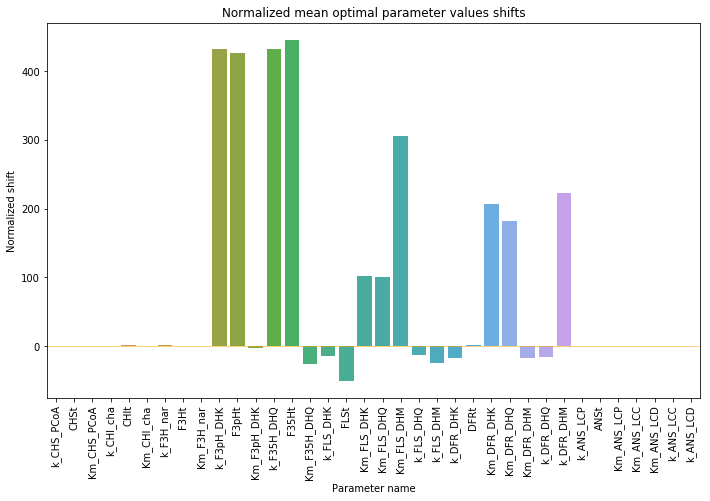

In [175]:
# Plot the shifts between starting parameter values and mean optimal parameter values

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(list(param_shift_dict.keys()), list(param_shift_dict.values()))

plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.15)
plt.title("Normalized mean optimal parameter values shifts")
plt.axhline(0, linewidth=0.5, color="Orange")
plt.ylabel("Normalized shift")
plt.xlabel("Parameter name");
plt.gcf().subplots_adjust(bottom=0.25)

#plt.savefig("mean-optimal-param-shifts.pdf", format="pdf")

/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



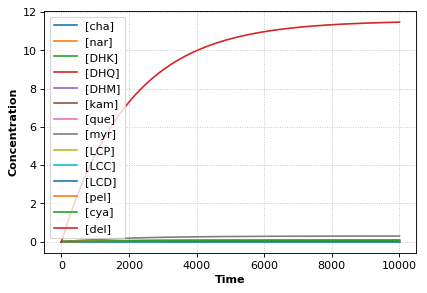

In [132]:
#r.conservedMoietyAnalysis = True
rr.integrator = 'cvode' #'cvode' is the numerical non-stochastic solver
#rr.resetToOrigin() #This prevents the model from retaining memory of simulation
rr.simulate(0, 10000, 1000)
rr.plot(xtitle="Time", ytitle="Concentration")

The total concentration is 12.206331451814181mM


/home/lcwheeler/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning:

findfont: Font family ['georgia'] not found. Falling back to DejaVu Sans



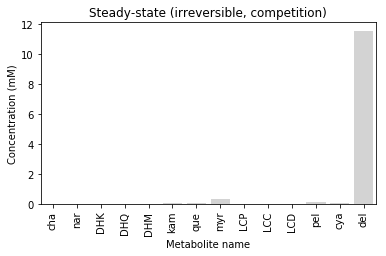

In [134]:
#r.conservedMoietyAnalysis = True
SS_selections = rr.steadyStateSelections = list(rr.getFloatingSpeciesIds()) 
SS_values = rr.getSteadyStateValues()

sns.barplot(SS_selections, SS_values, color="lightgray")
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.15)
plt.title("Steady-state (irreversible, competition)")
plt.ylabel("Concentration (mM)")
plt.xlabel("Metabolite name");
plt.gcf().subplots_adjust(bottom=0.25)
print("The total concentration is " + str(np.sum(SS_values)) + "mM")
#plt.savefig("steady-state-concentrations-mean-optimal.pdf")

In [143]:
# Calculate the proportion of total steady state concentration that is delphinidin (index 13)
SS_values[13]/np.sum(SS_values)

0.9456279869410819

## Min, median, and max values for fixed selection coefficients (and fixation probabilities for min and max)

In [10]:
Ss = []
for key in dataset.pathway_set.keys():
    for i in range(len(dataset.pathway_set[key].parameters)):
        Ss.append(dataset.pathway_set[key].parameters[i][2])

In [11]:
print(np.min(Ss))
print(np.median(Ss))
print(np.max(Ss))

2.3659593938463175e-06
0.043911865466527866
0.4294231344866921
